In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import scipy.io

from leitmotifs.plotting import *
from leitmotifs.lama import *

from leitmotifs.competitors import *

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")



def plot_motiflet(series, motiflet, dims, motif_length, title=None):    
    fig, ax = plt.subplots(figsize=(4,2))

    offset = 0.0
    for dim in dims:
        dim_data_raw = pd.DataFrame(data=np.array([series[dim, i:i+motif_length] for i in motiflet]))        
        offset -= 2 * (dim_data_raw.values.max() - dim_data_raw.values.min())
        ax = sns.lineplot(data=dim_data_raw.melt().set_index("variable") + offset)
        
    if title:
        ax.set_title(title)
        
    sns.despine()
    fig.patch.set_visible(False)
    ax.legend().set_visible(False)
    ax.axis('off')
    return fig, ax
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


physio
	 ['physio', 0.0, 0.0]
Boxing
	 ['Boxing', 0.3333333333333333, 0.4]
	 [ 255  303  389  543  631  677  721 1091 1315 1643 1763 1847 2211 2253
 2529 2633 2671 2863 3099 3217 3369 3483 3575 3611 3729 3945 3985 4061
 4479 4627 4671 4709]
	 [13]
	 5
Swordplay
	 ['Swordplay', 0.0, 0.0]
Basketball
	 ['Basketball', 0.5, 0.2]
	 [  1 629]
	 [5]
	 33
Charleston - Side By Side Female
	 ['Charleston - Side By Side Female', 0.5, 0.3333333333333333]
	 [ 49 215 375]
	 [0]
	 5
The file ../tests/smm_benchmark/results/2/Motif_6_DepO_2_DepT_2.mat does not exist.
birds
	 ['birds', 0.0, 0.0]
	 [ 120  226  306  326  546  736  760  842 2118 2263 2526 2790]
	 [1]
	 5
What I've Done - Linkin Park
	 ["What I've Done - Linkin Park", 0.37333333333333335, 1.0]
	 [ 309  617  694  716  748  831  922  978 1169 1222 1590 1897 2172 2454
 2811 2887 3014 3126 3197 3319 3328 3362 3546 3585 3634 3662 3821 4202
 4361 4414 4529 4702 4738 4848 4878 5022 5066 5205 5270 5399 5581 5713
 5755 5803 5887 5929 6039 6057 6145 6

{1: ['physio', 0.0, 0.0],
 2: ['Boxing', 0.3333333333333333, 0.4],
 3: ['Swordplay', 0.0, 0.0],
 4: ['Basketball', 0.5, 0.2],
 5: ['Charleston - Side By Side Female', 0.5, 0.3333333333333333],
 7: ['birds', 0.0, 0.0],
 8: ["What I've Done - Linkin Park", 0.37333333333333335, 1.0],
 9: ['Numb - Linkin Park', 0.14814814814814814, 0.8],
 10: ['Vanilla Ice - Ice Ice Baby', 0.49122807017543857, 1.0],
 11: ['Queen David Bowie - Under Pressure', 0.19672131147540983, 1.0],
 12: ['The Rolling Stones - Paint It, Black', 0.14285714285714285, 1.0],
 13: ['Star Wars - The Imperial March', 0.2619047619047619, 1.0],
 14: ['Lord of the Rings Symphony - The Shire', 0.275, 1.0]}

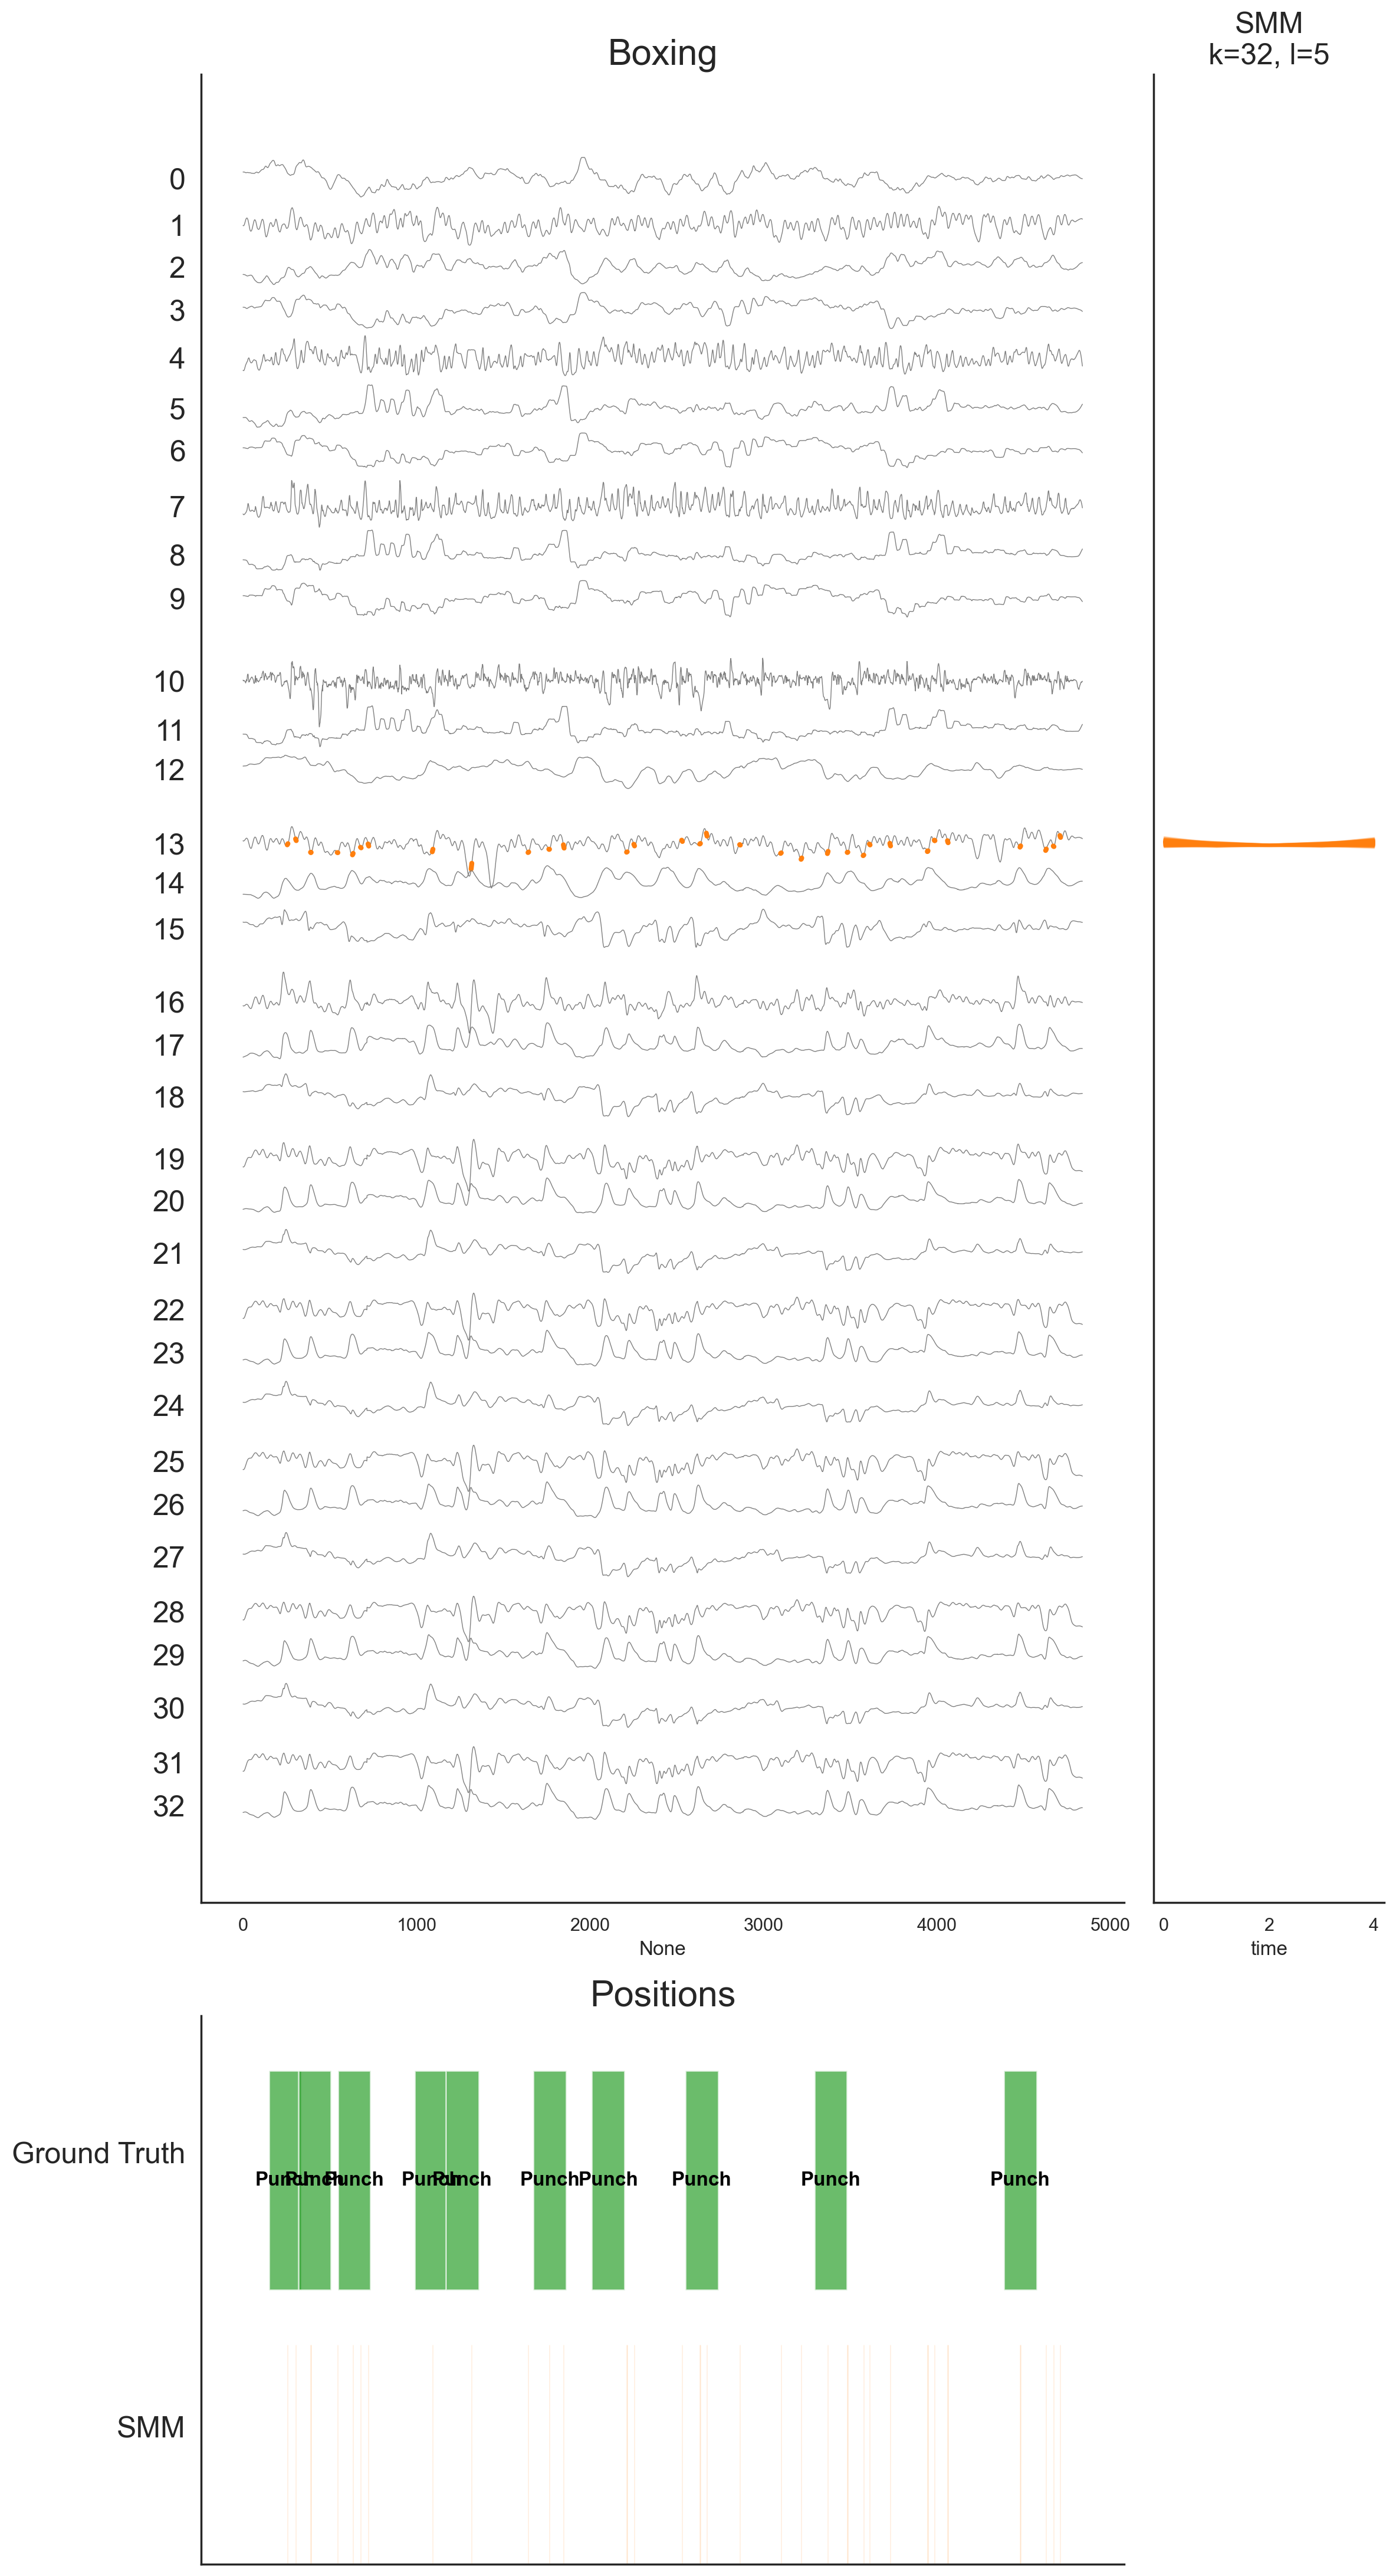

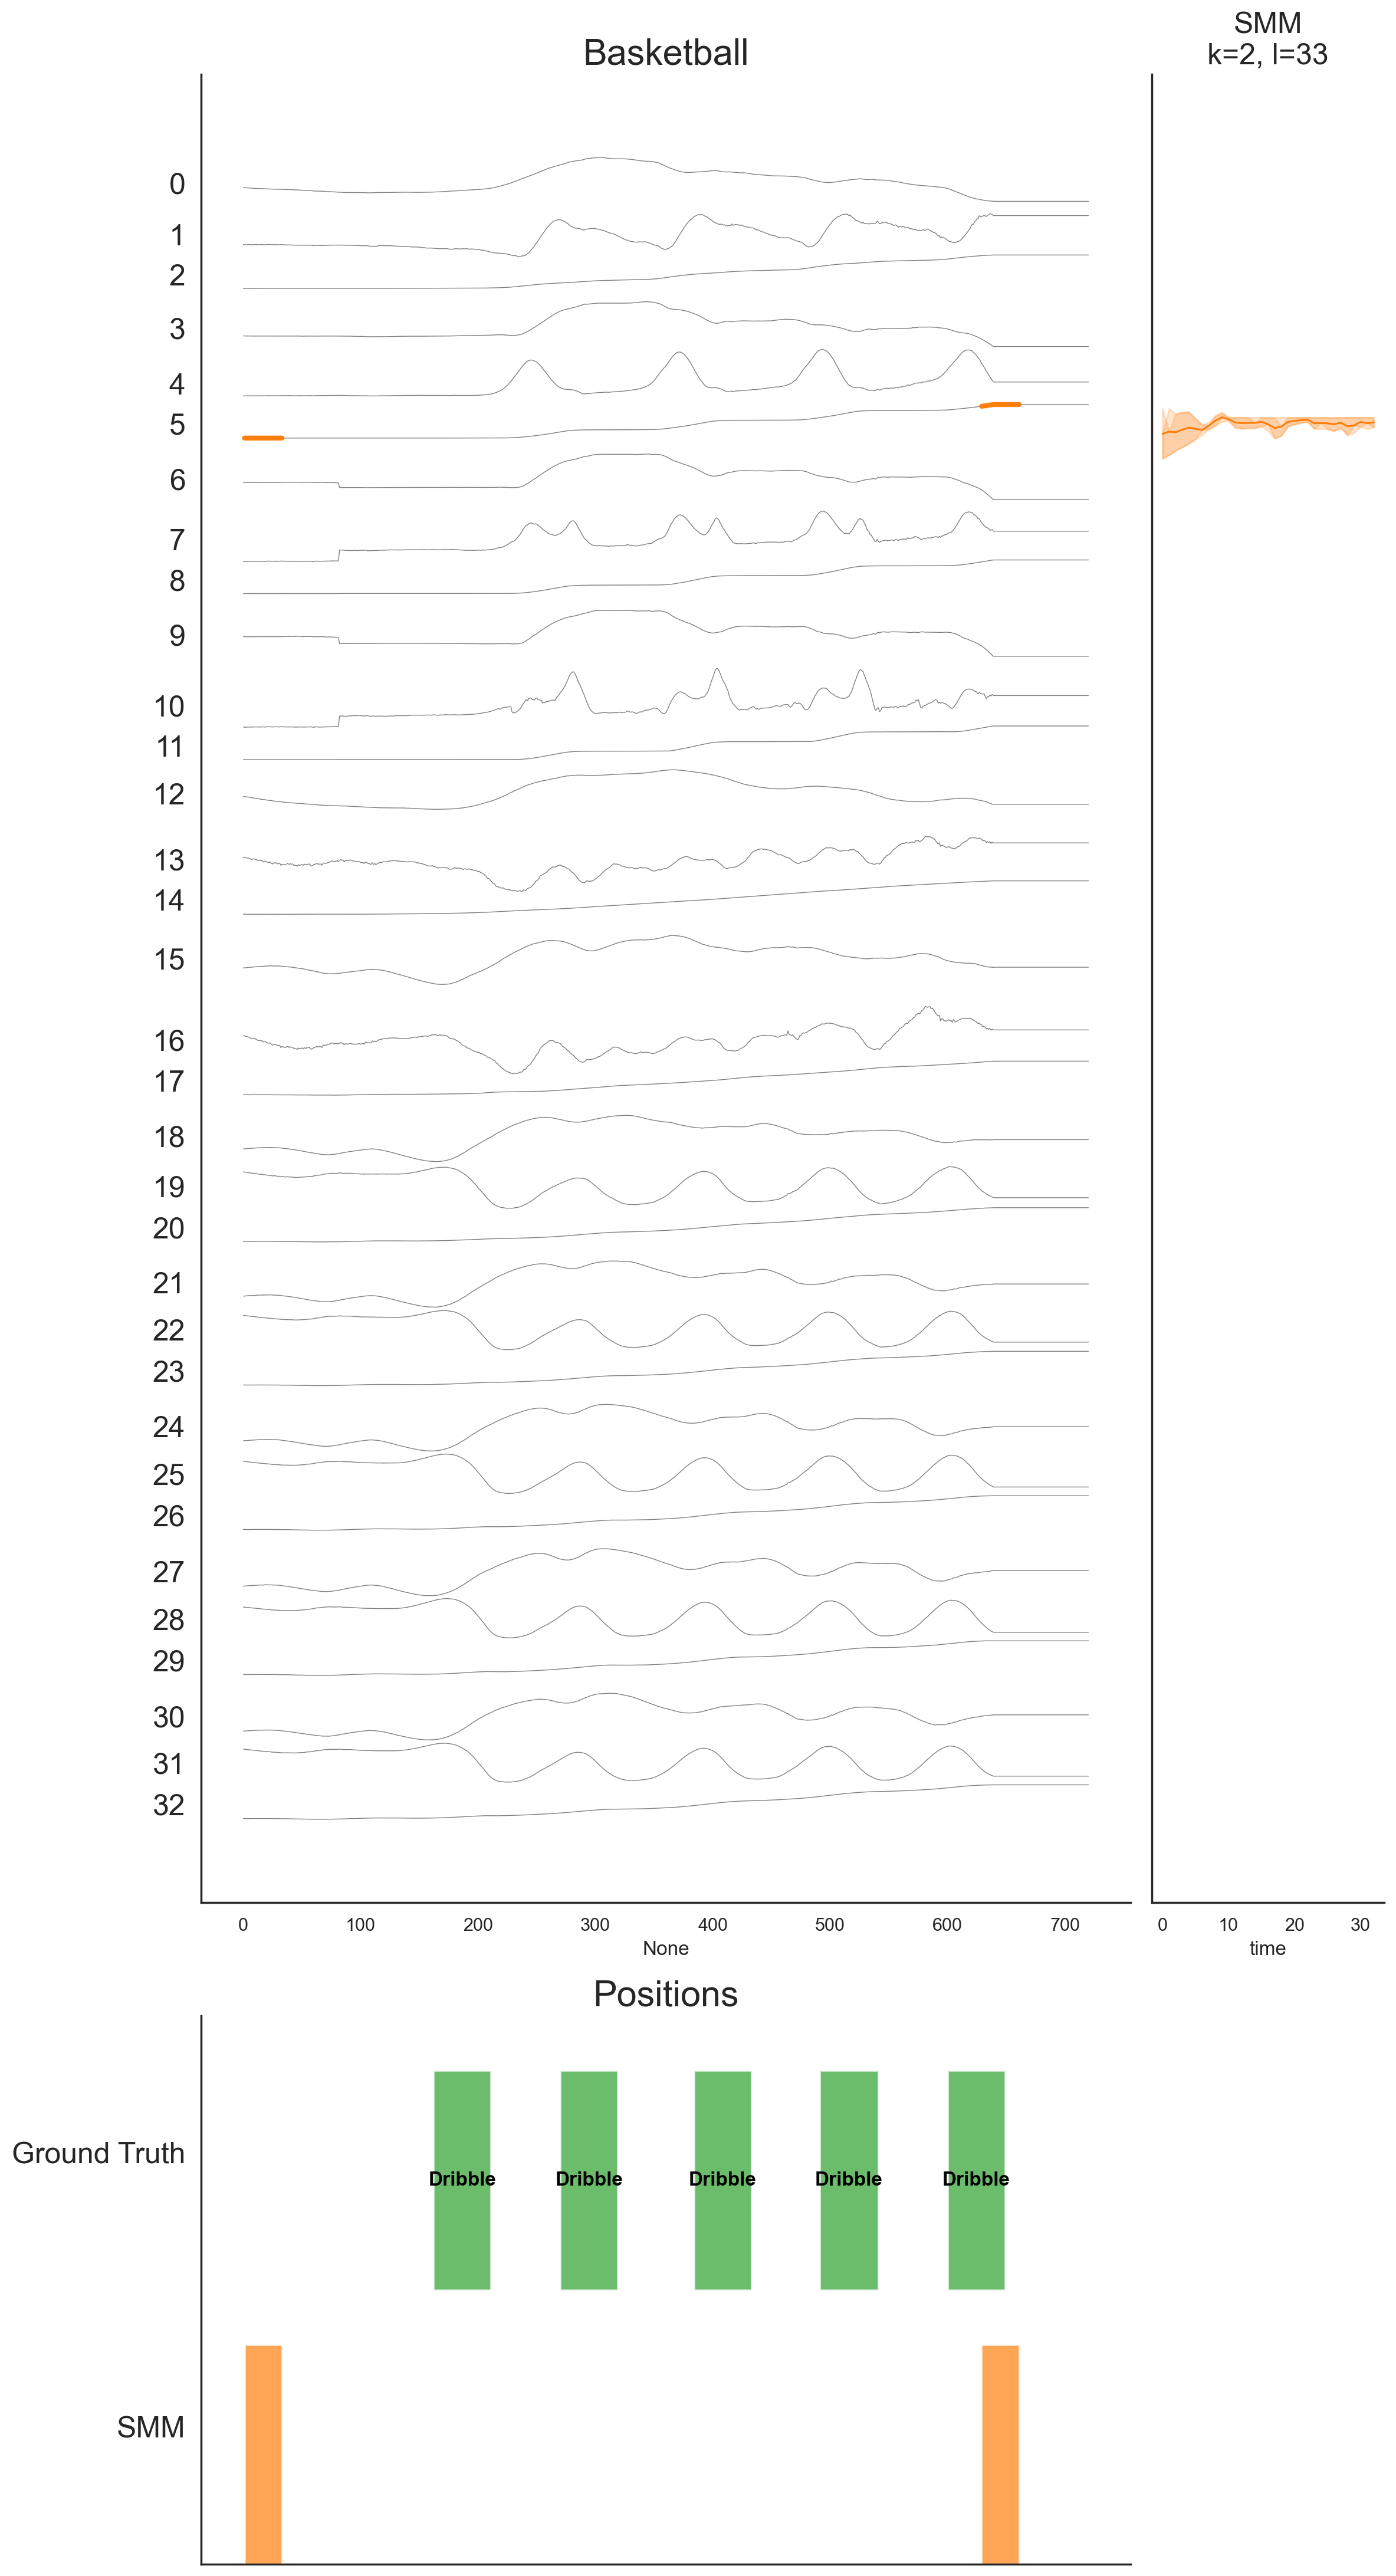

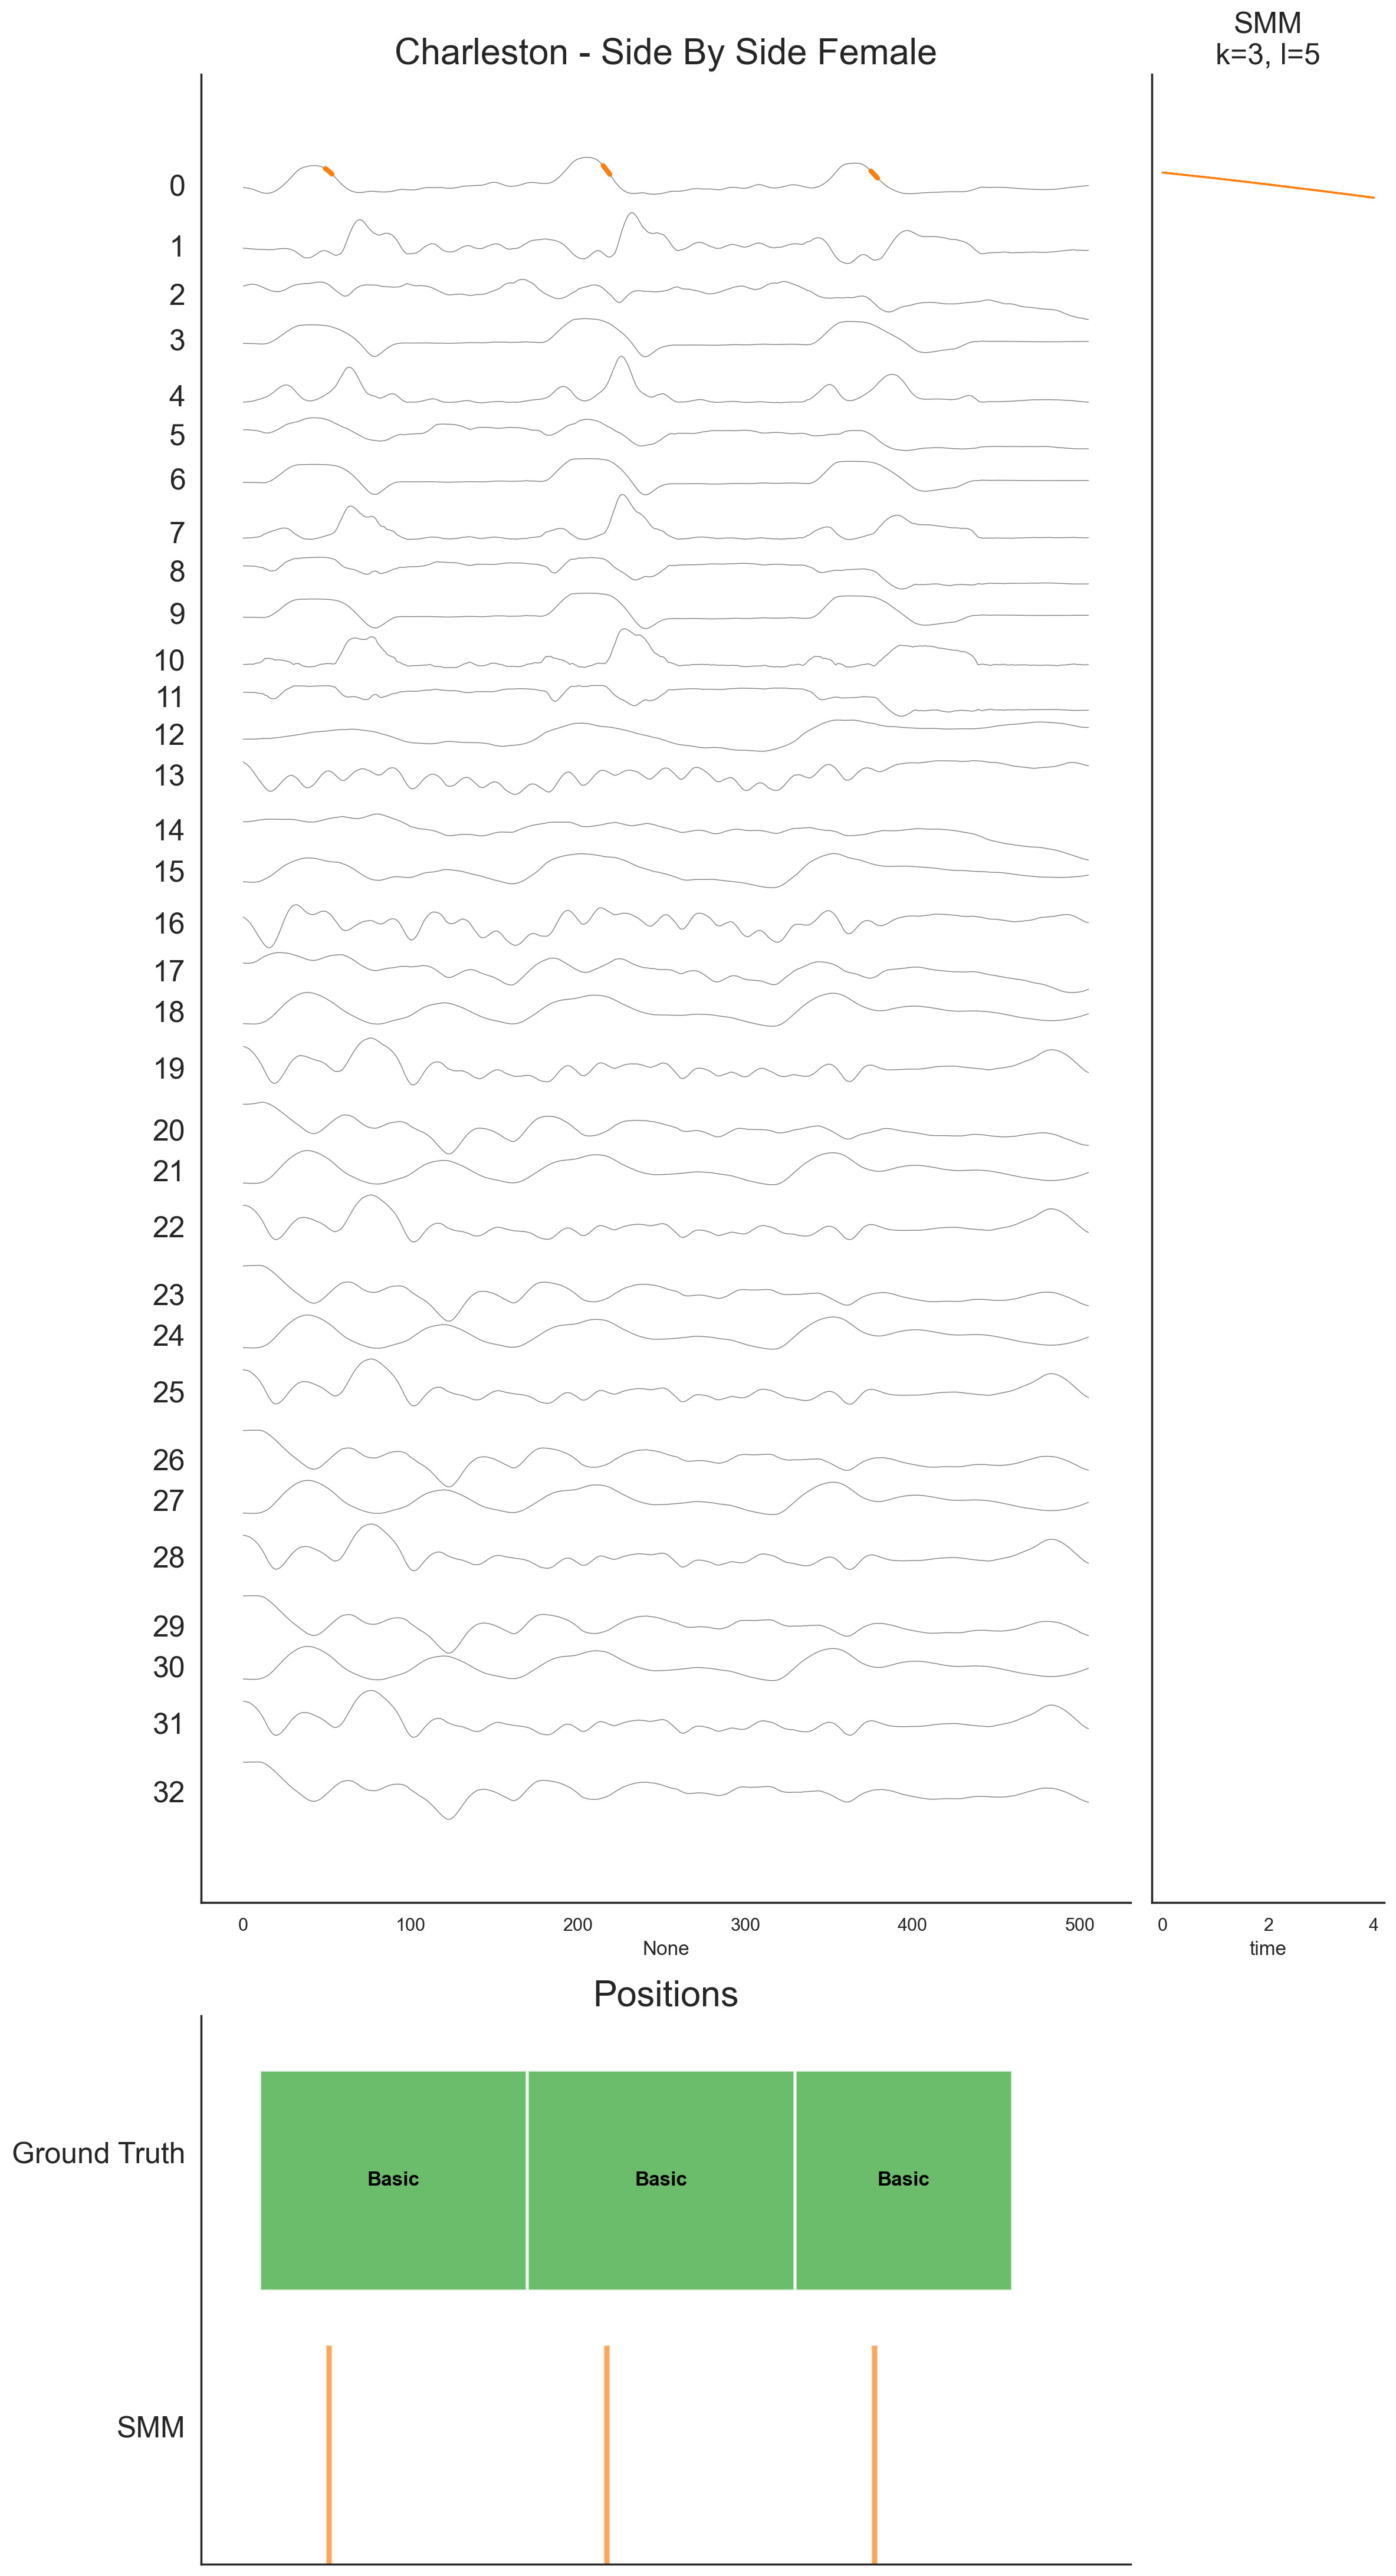

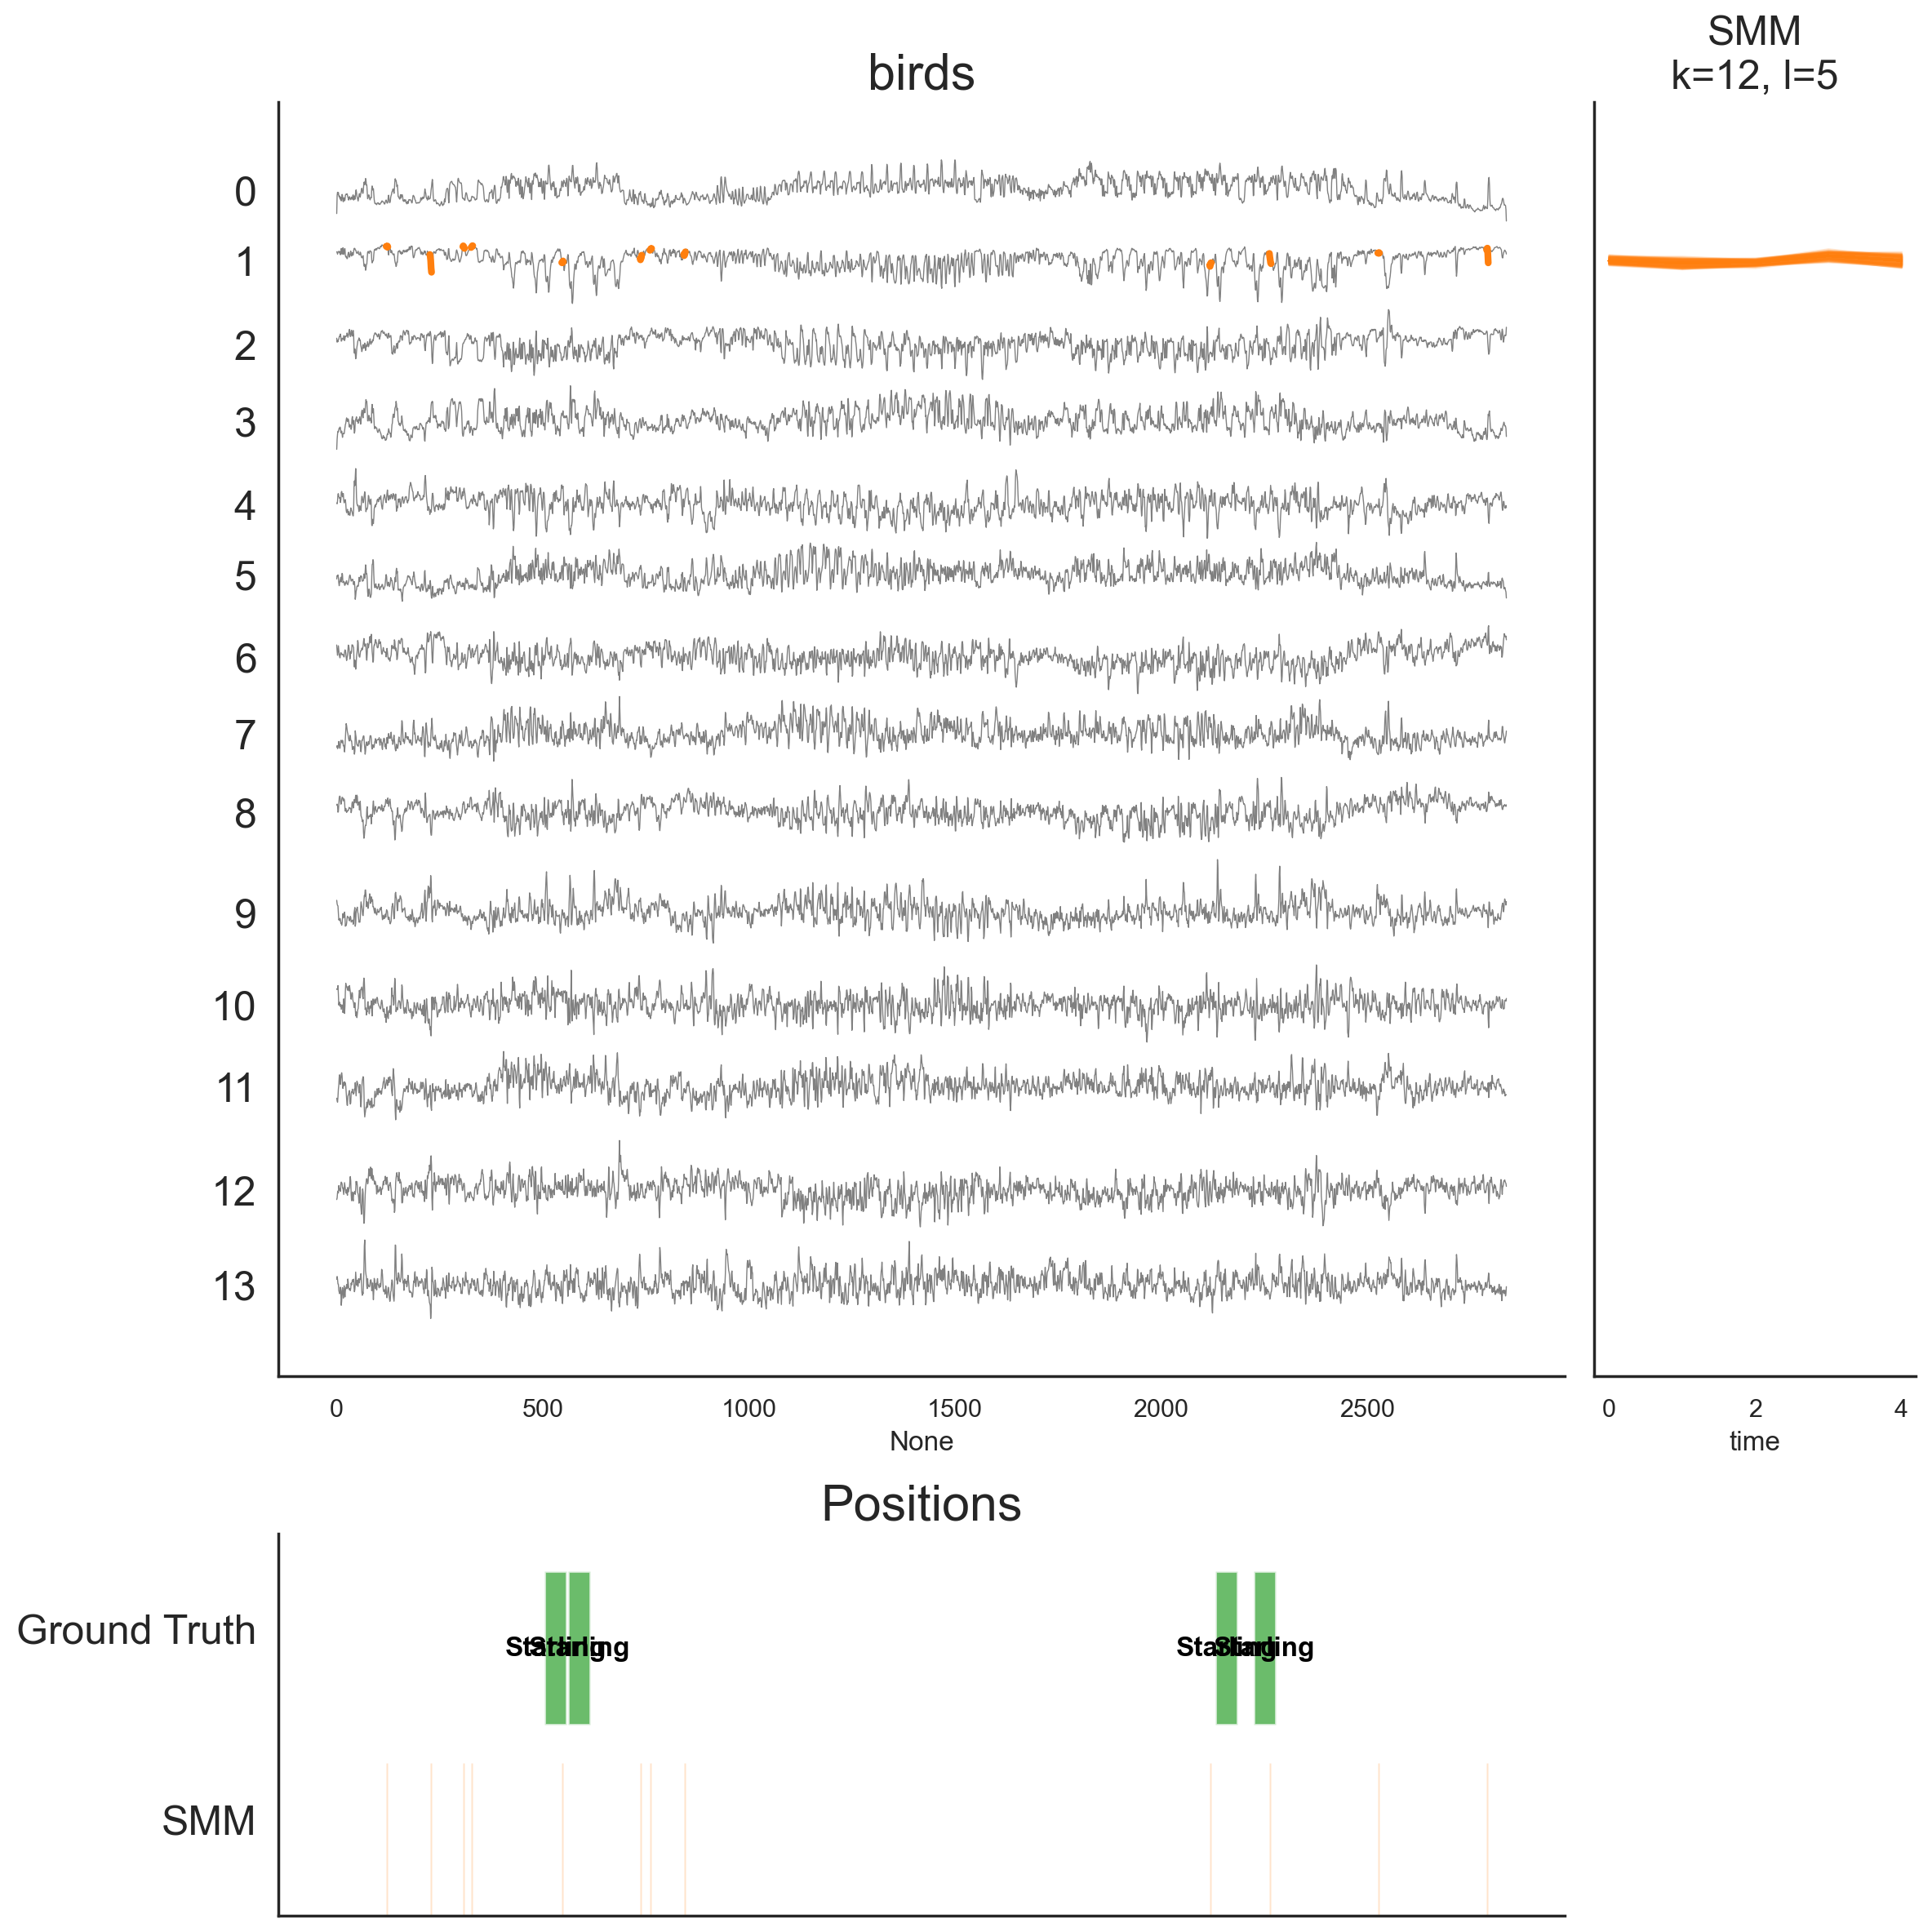

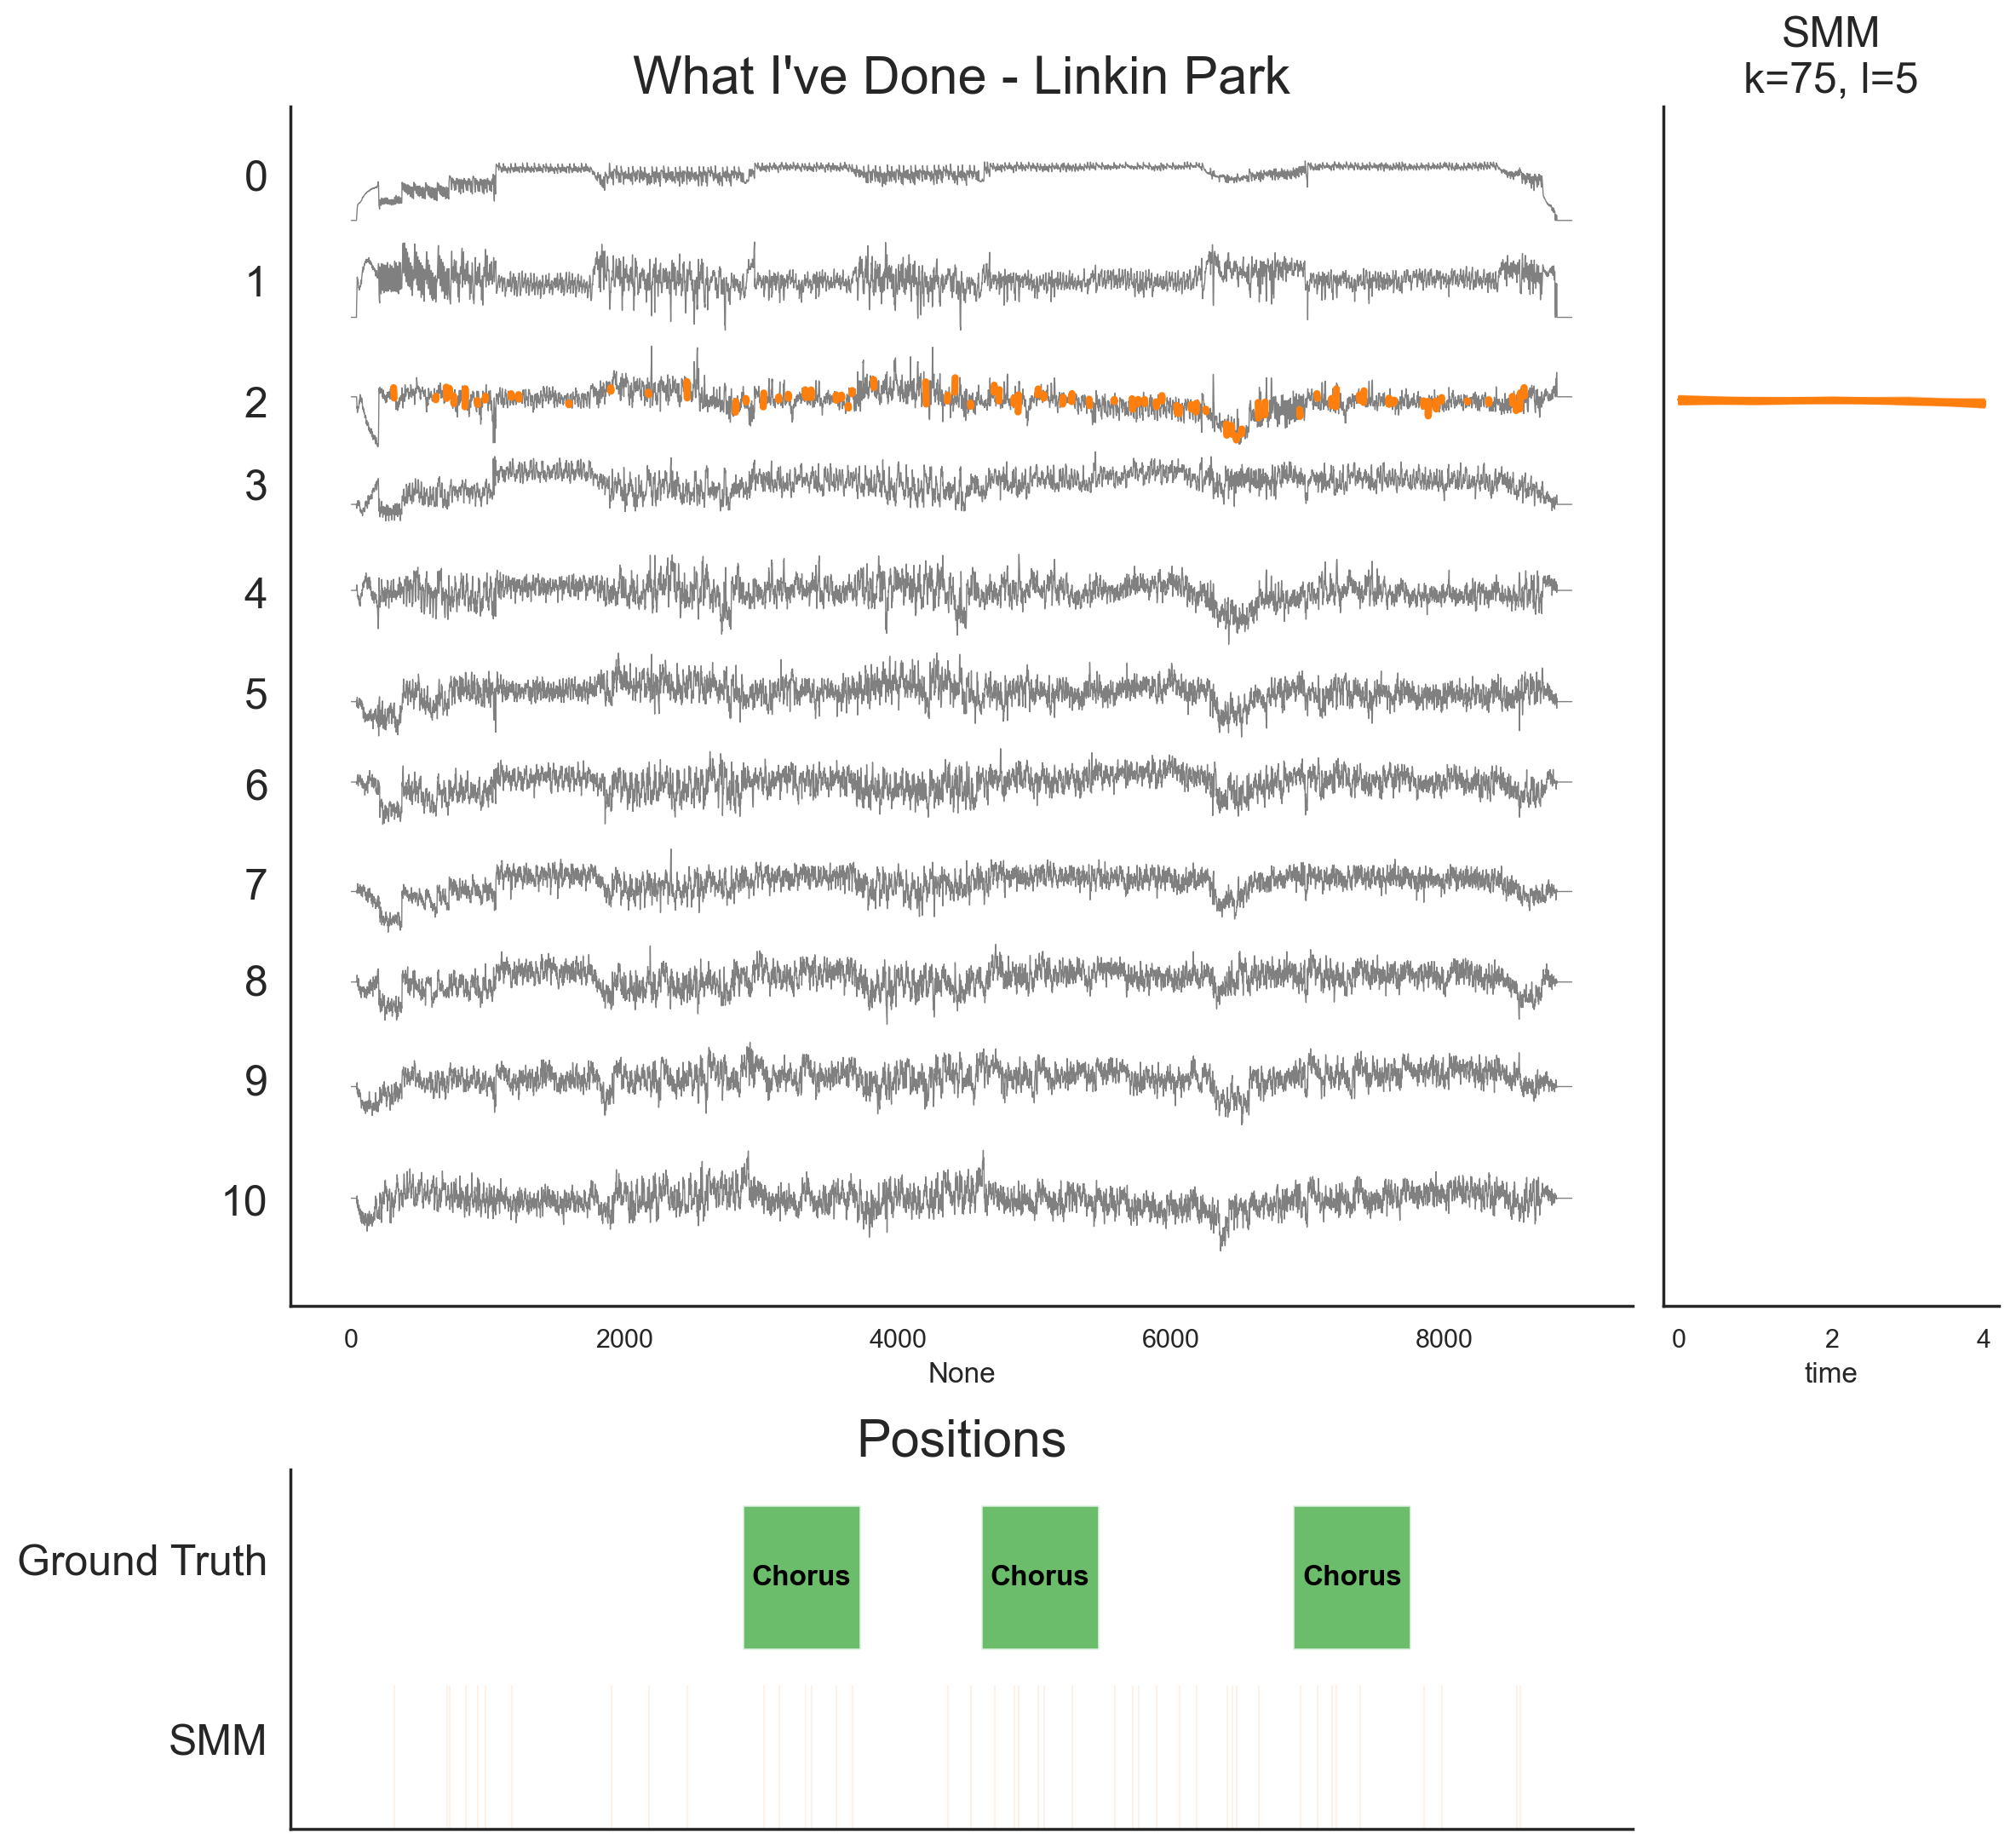

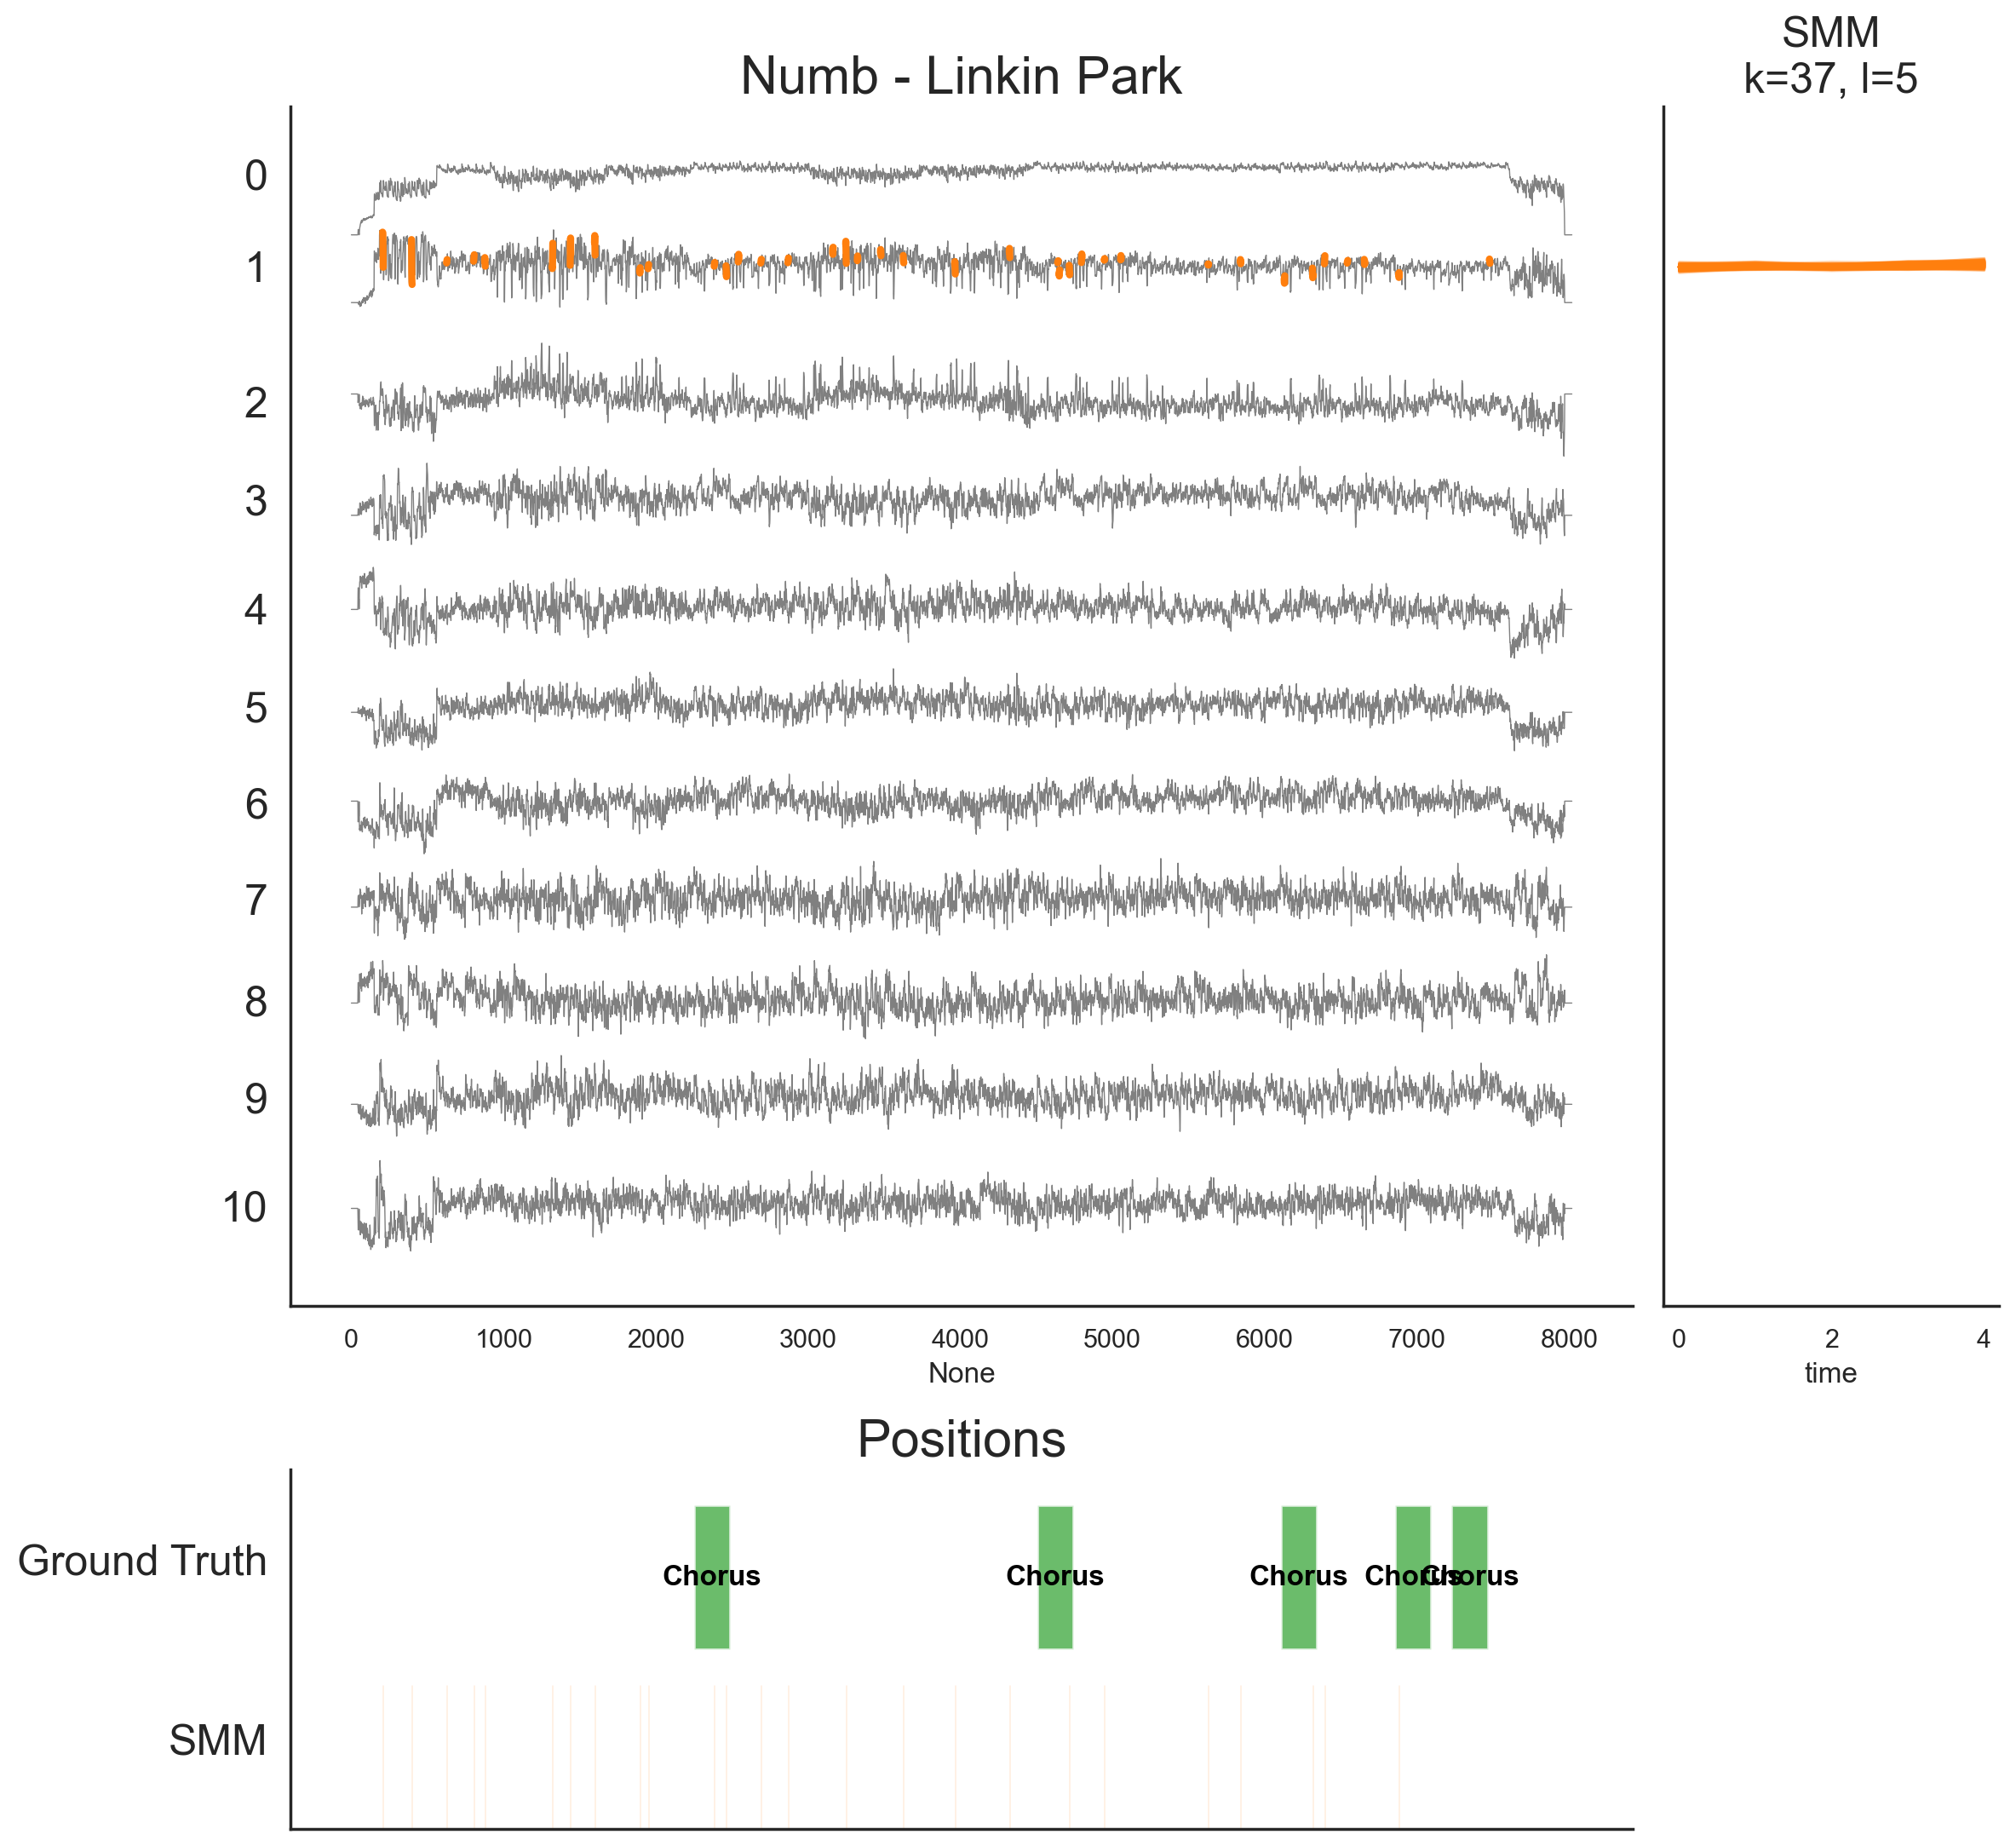

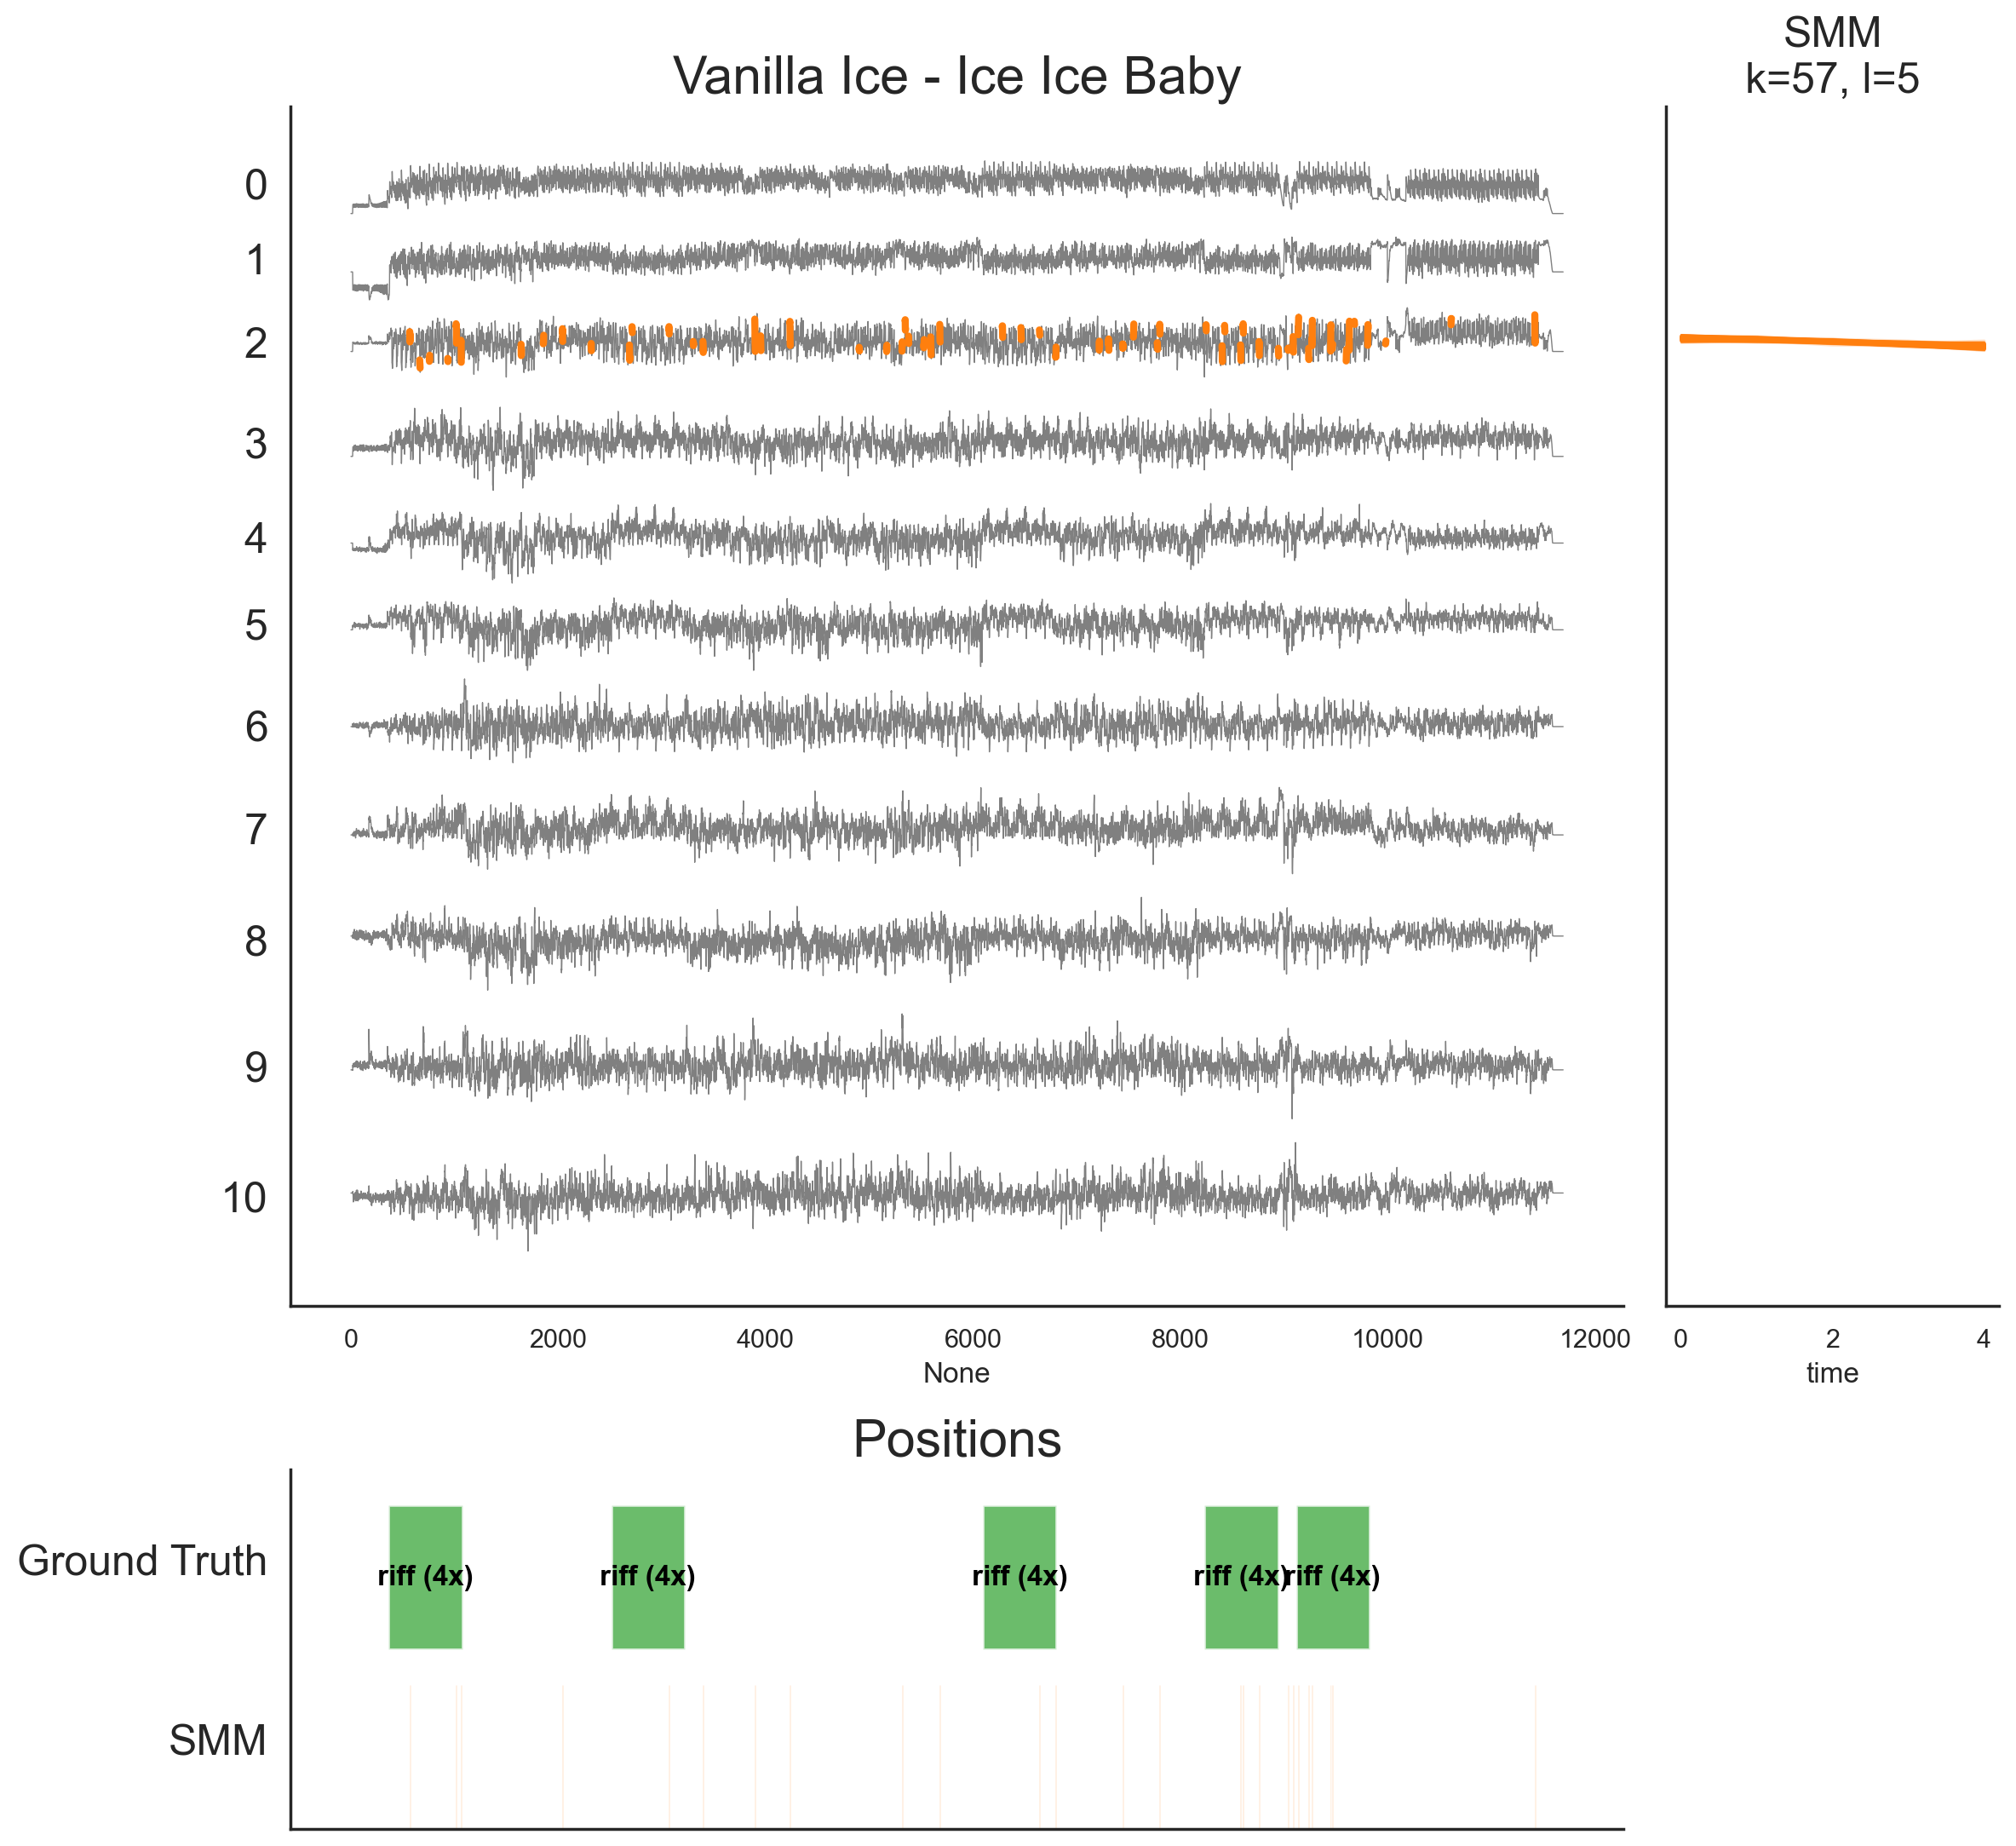

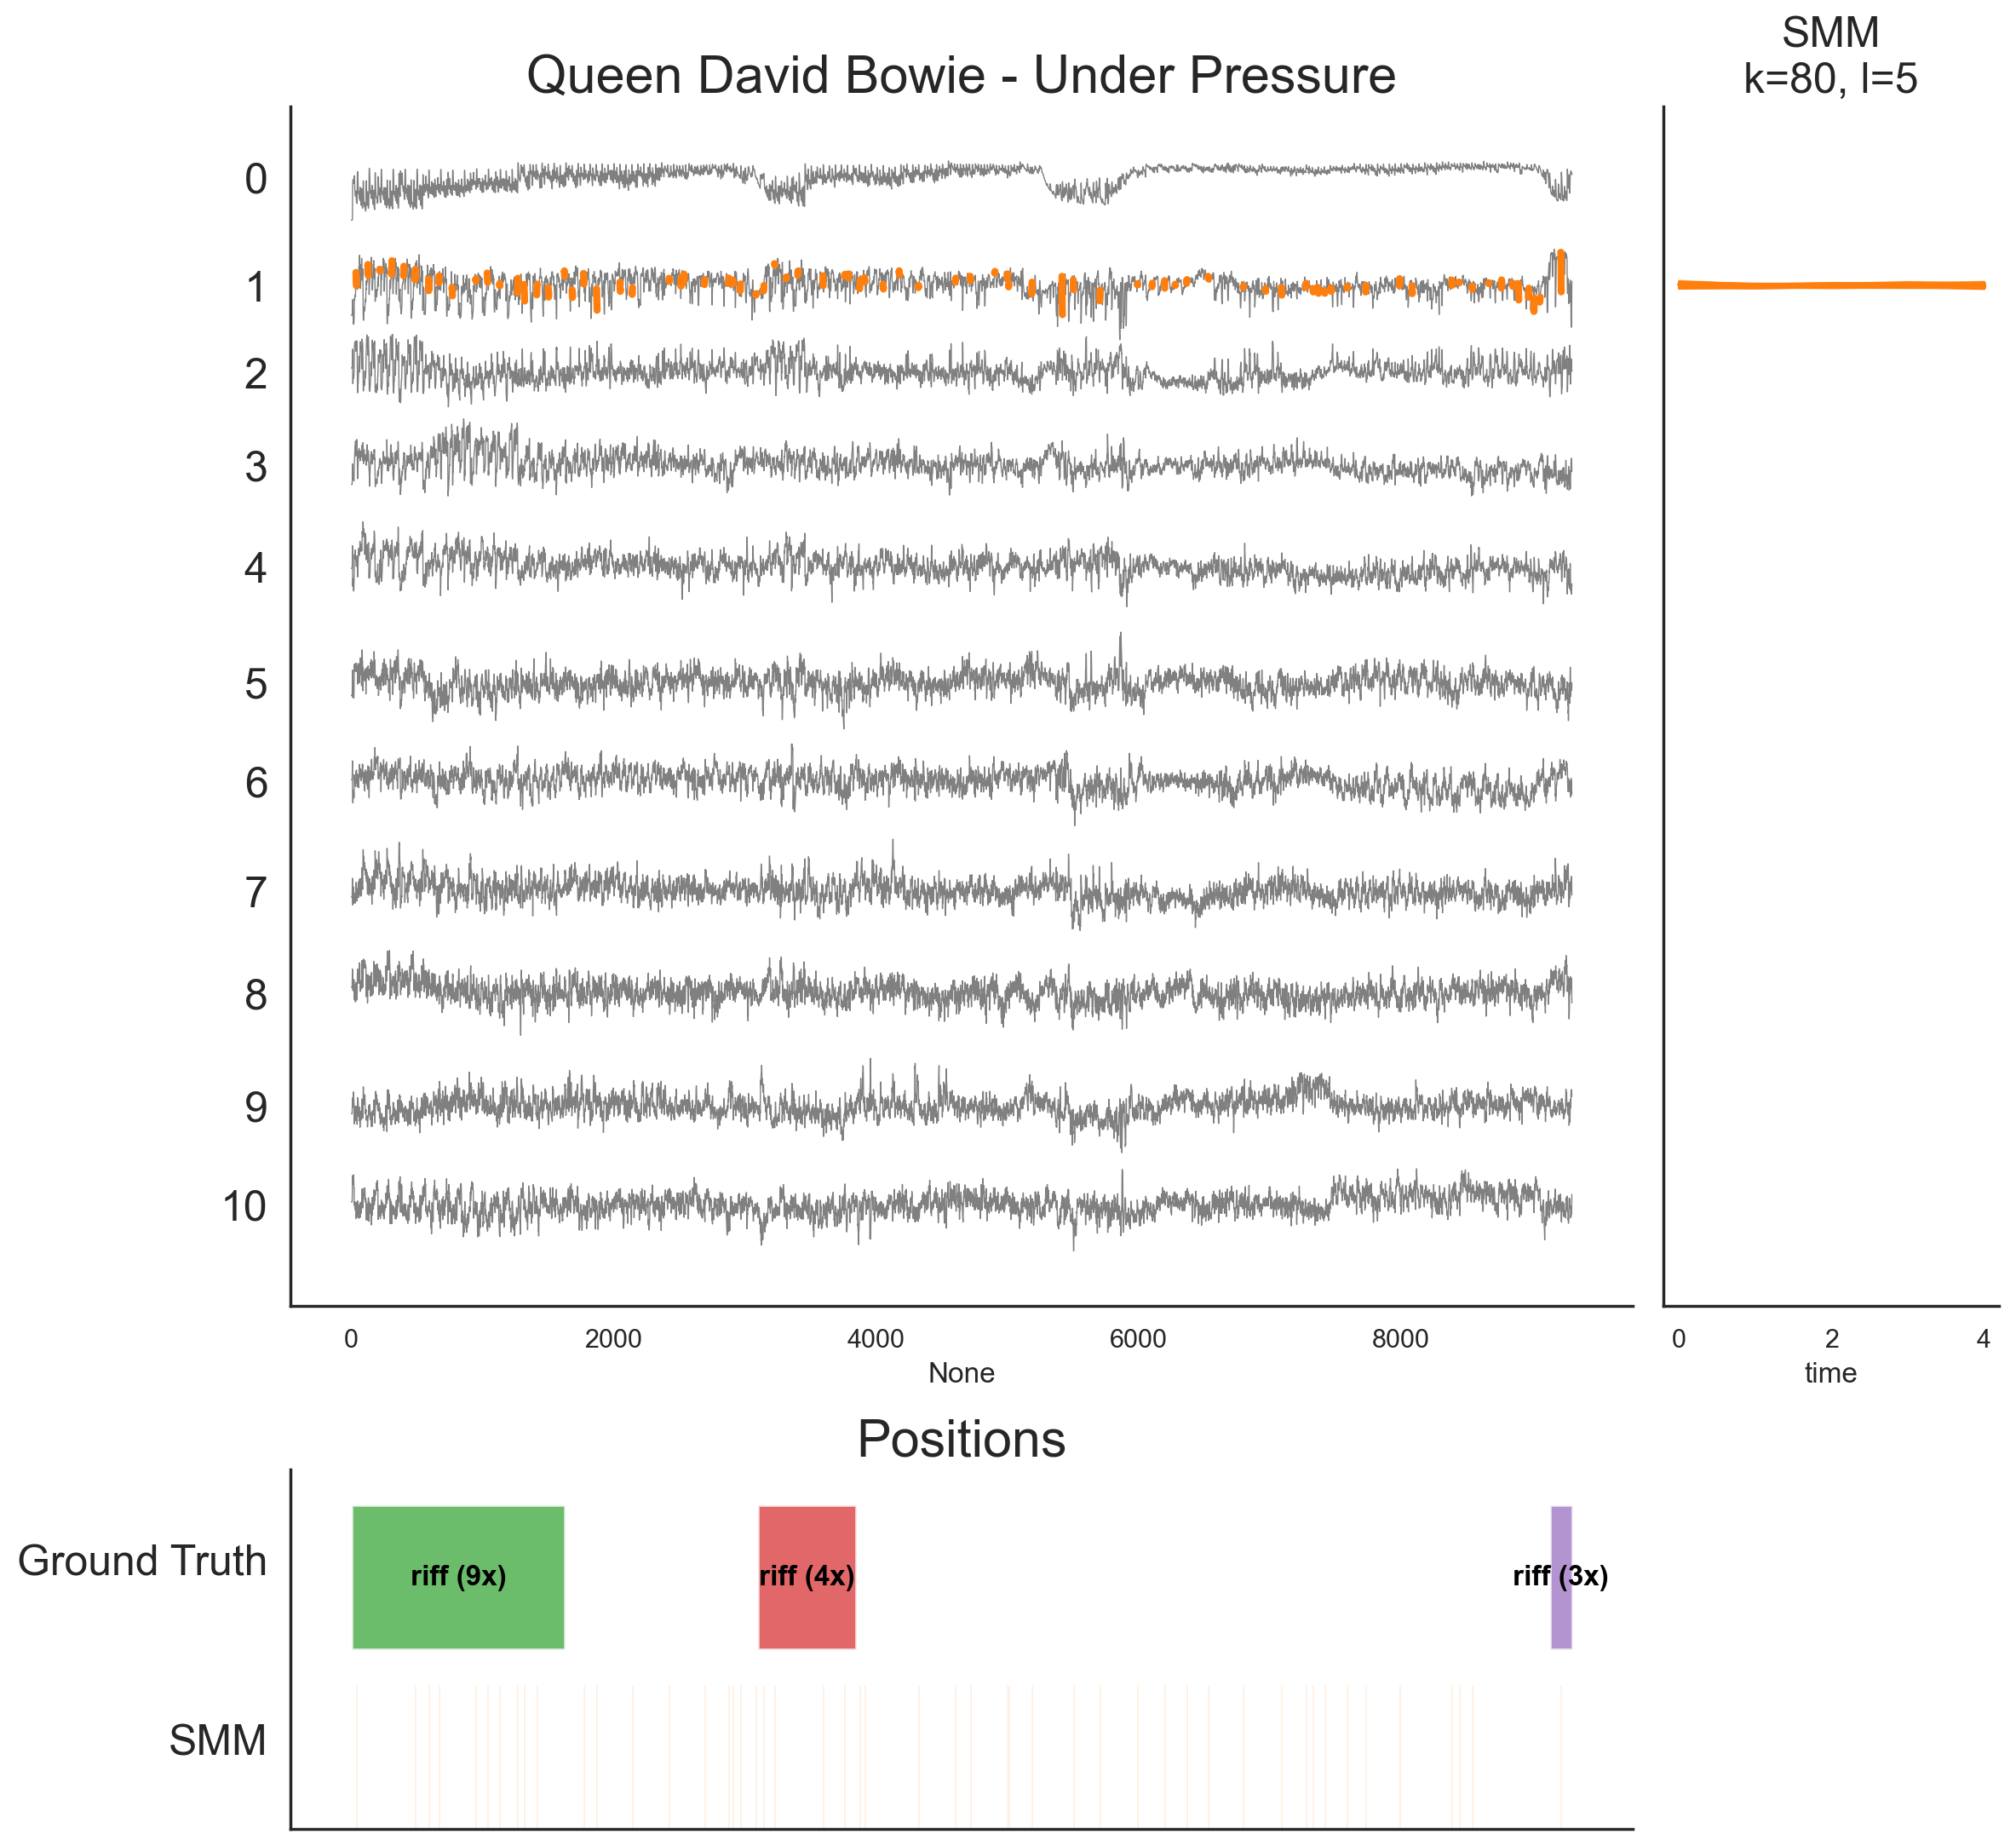

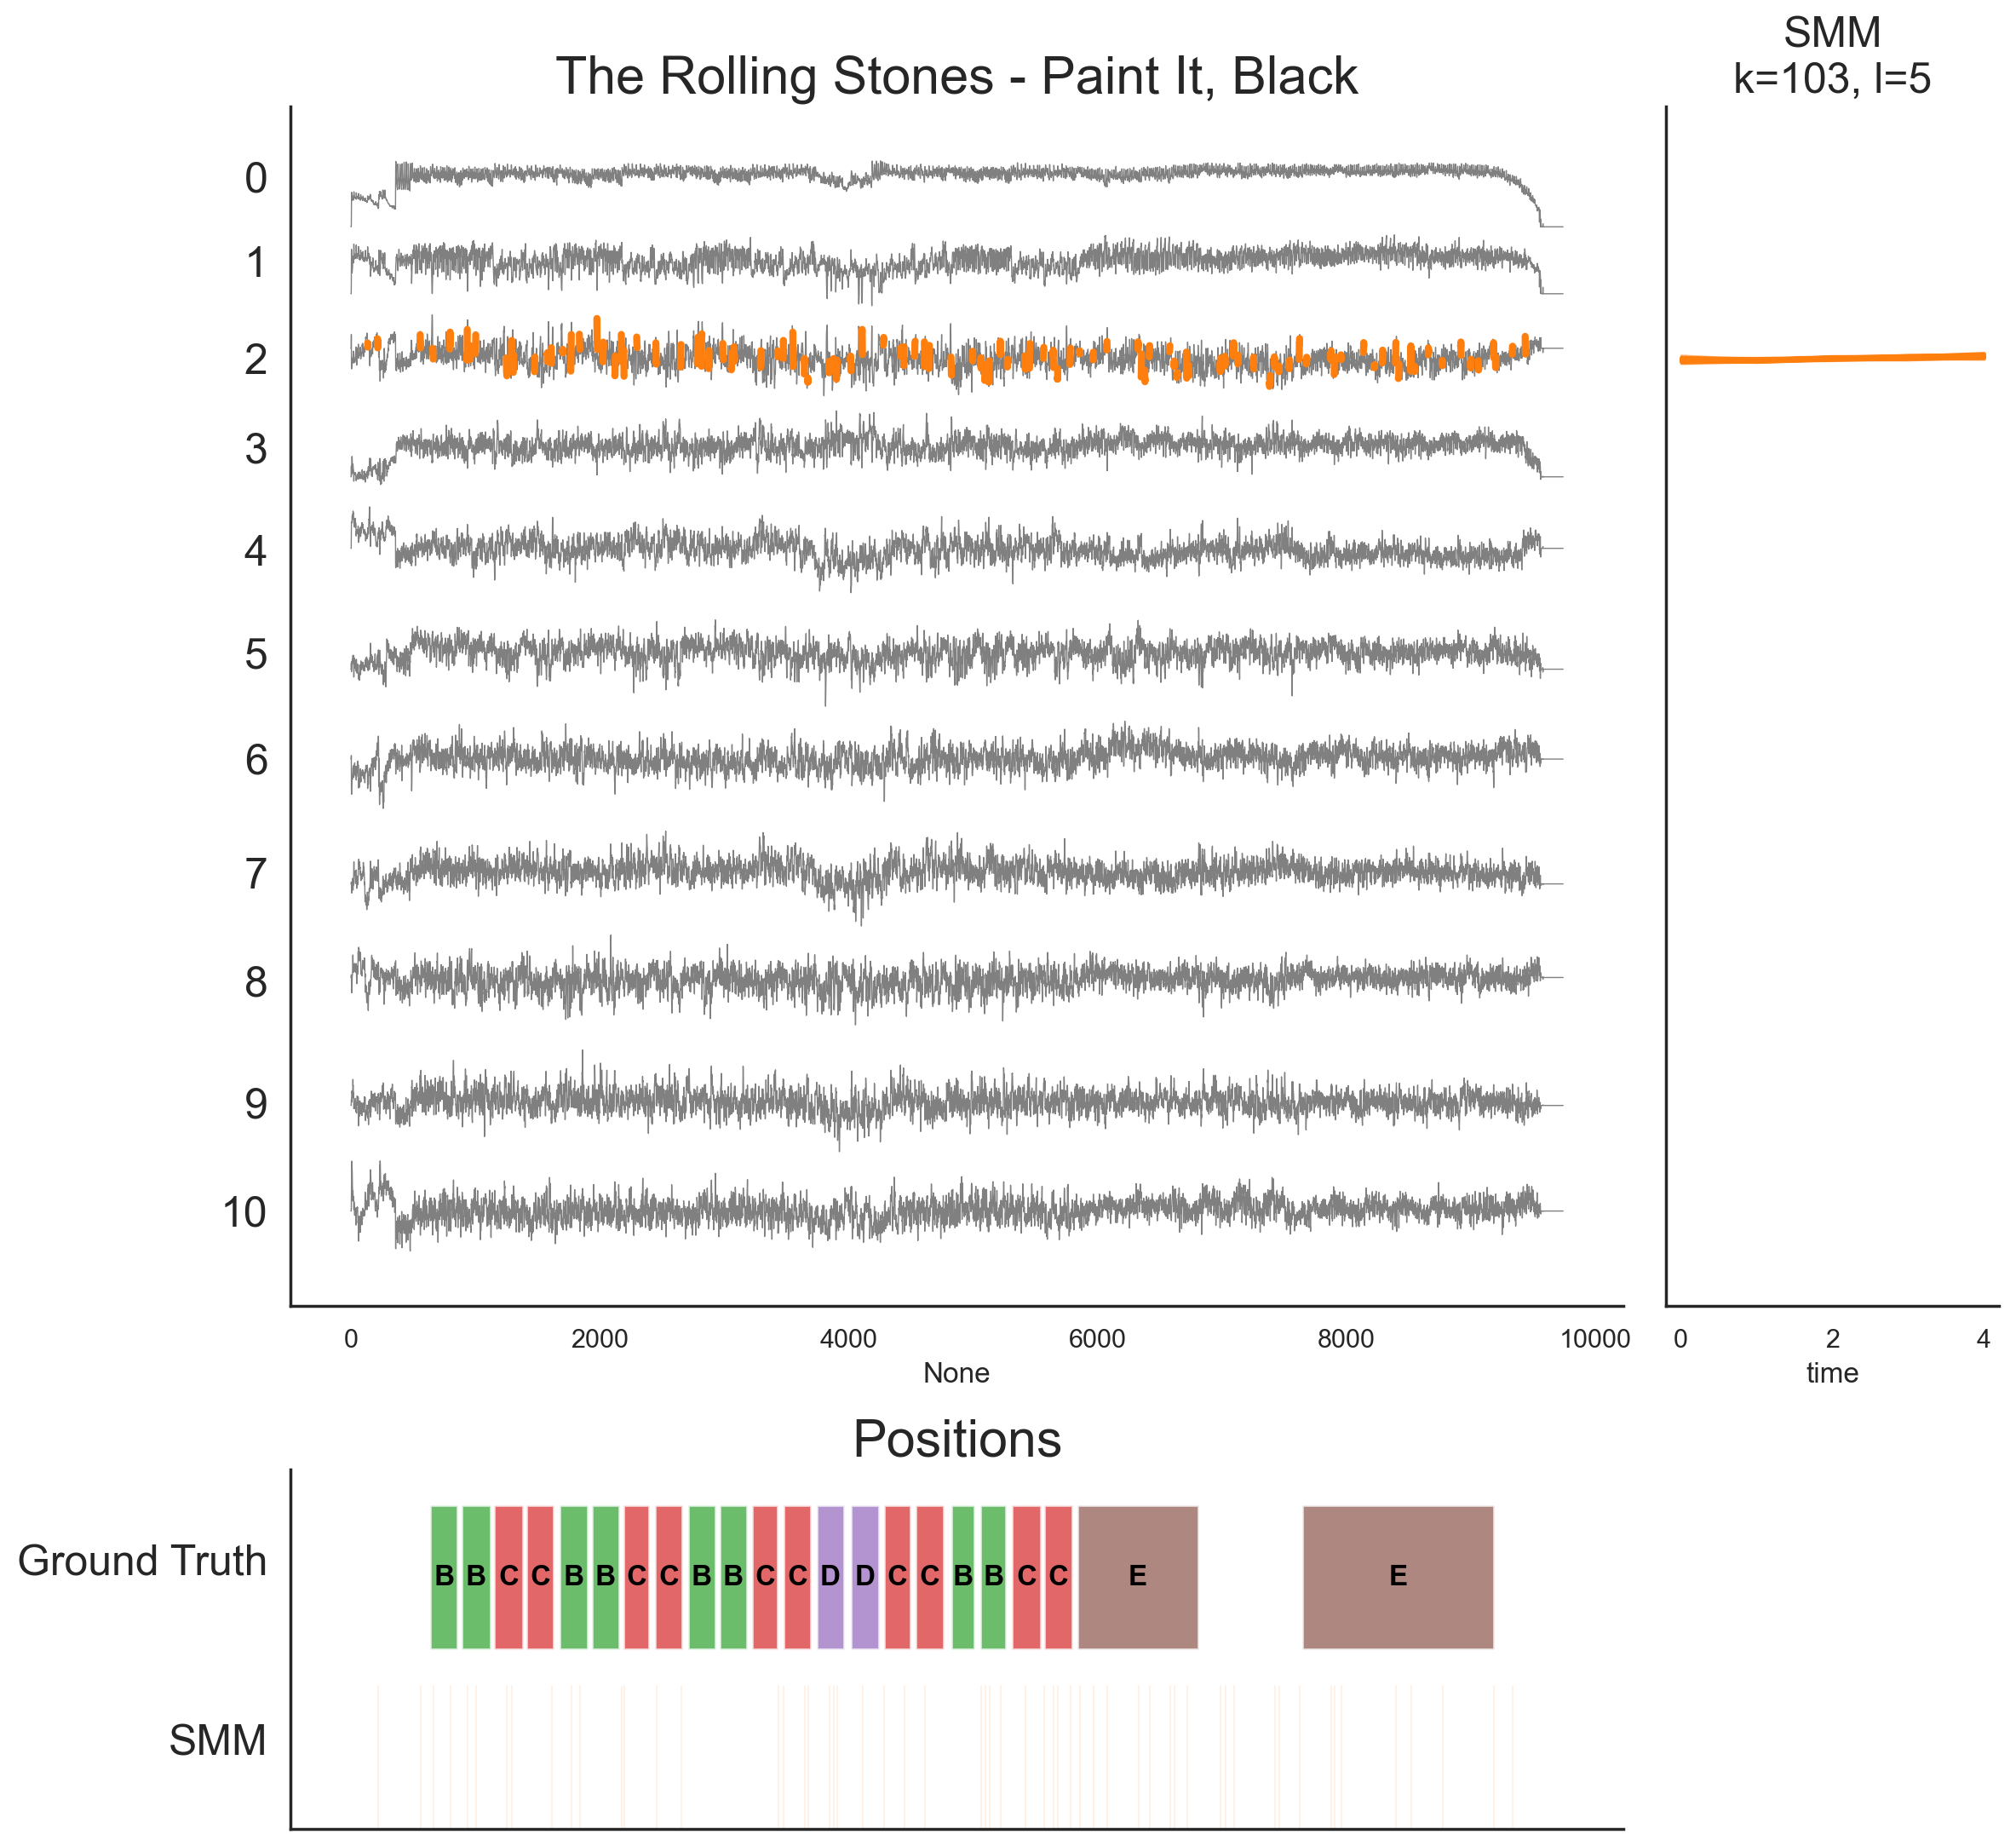

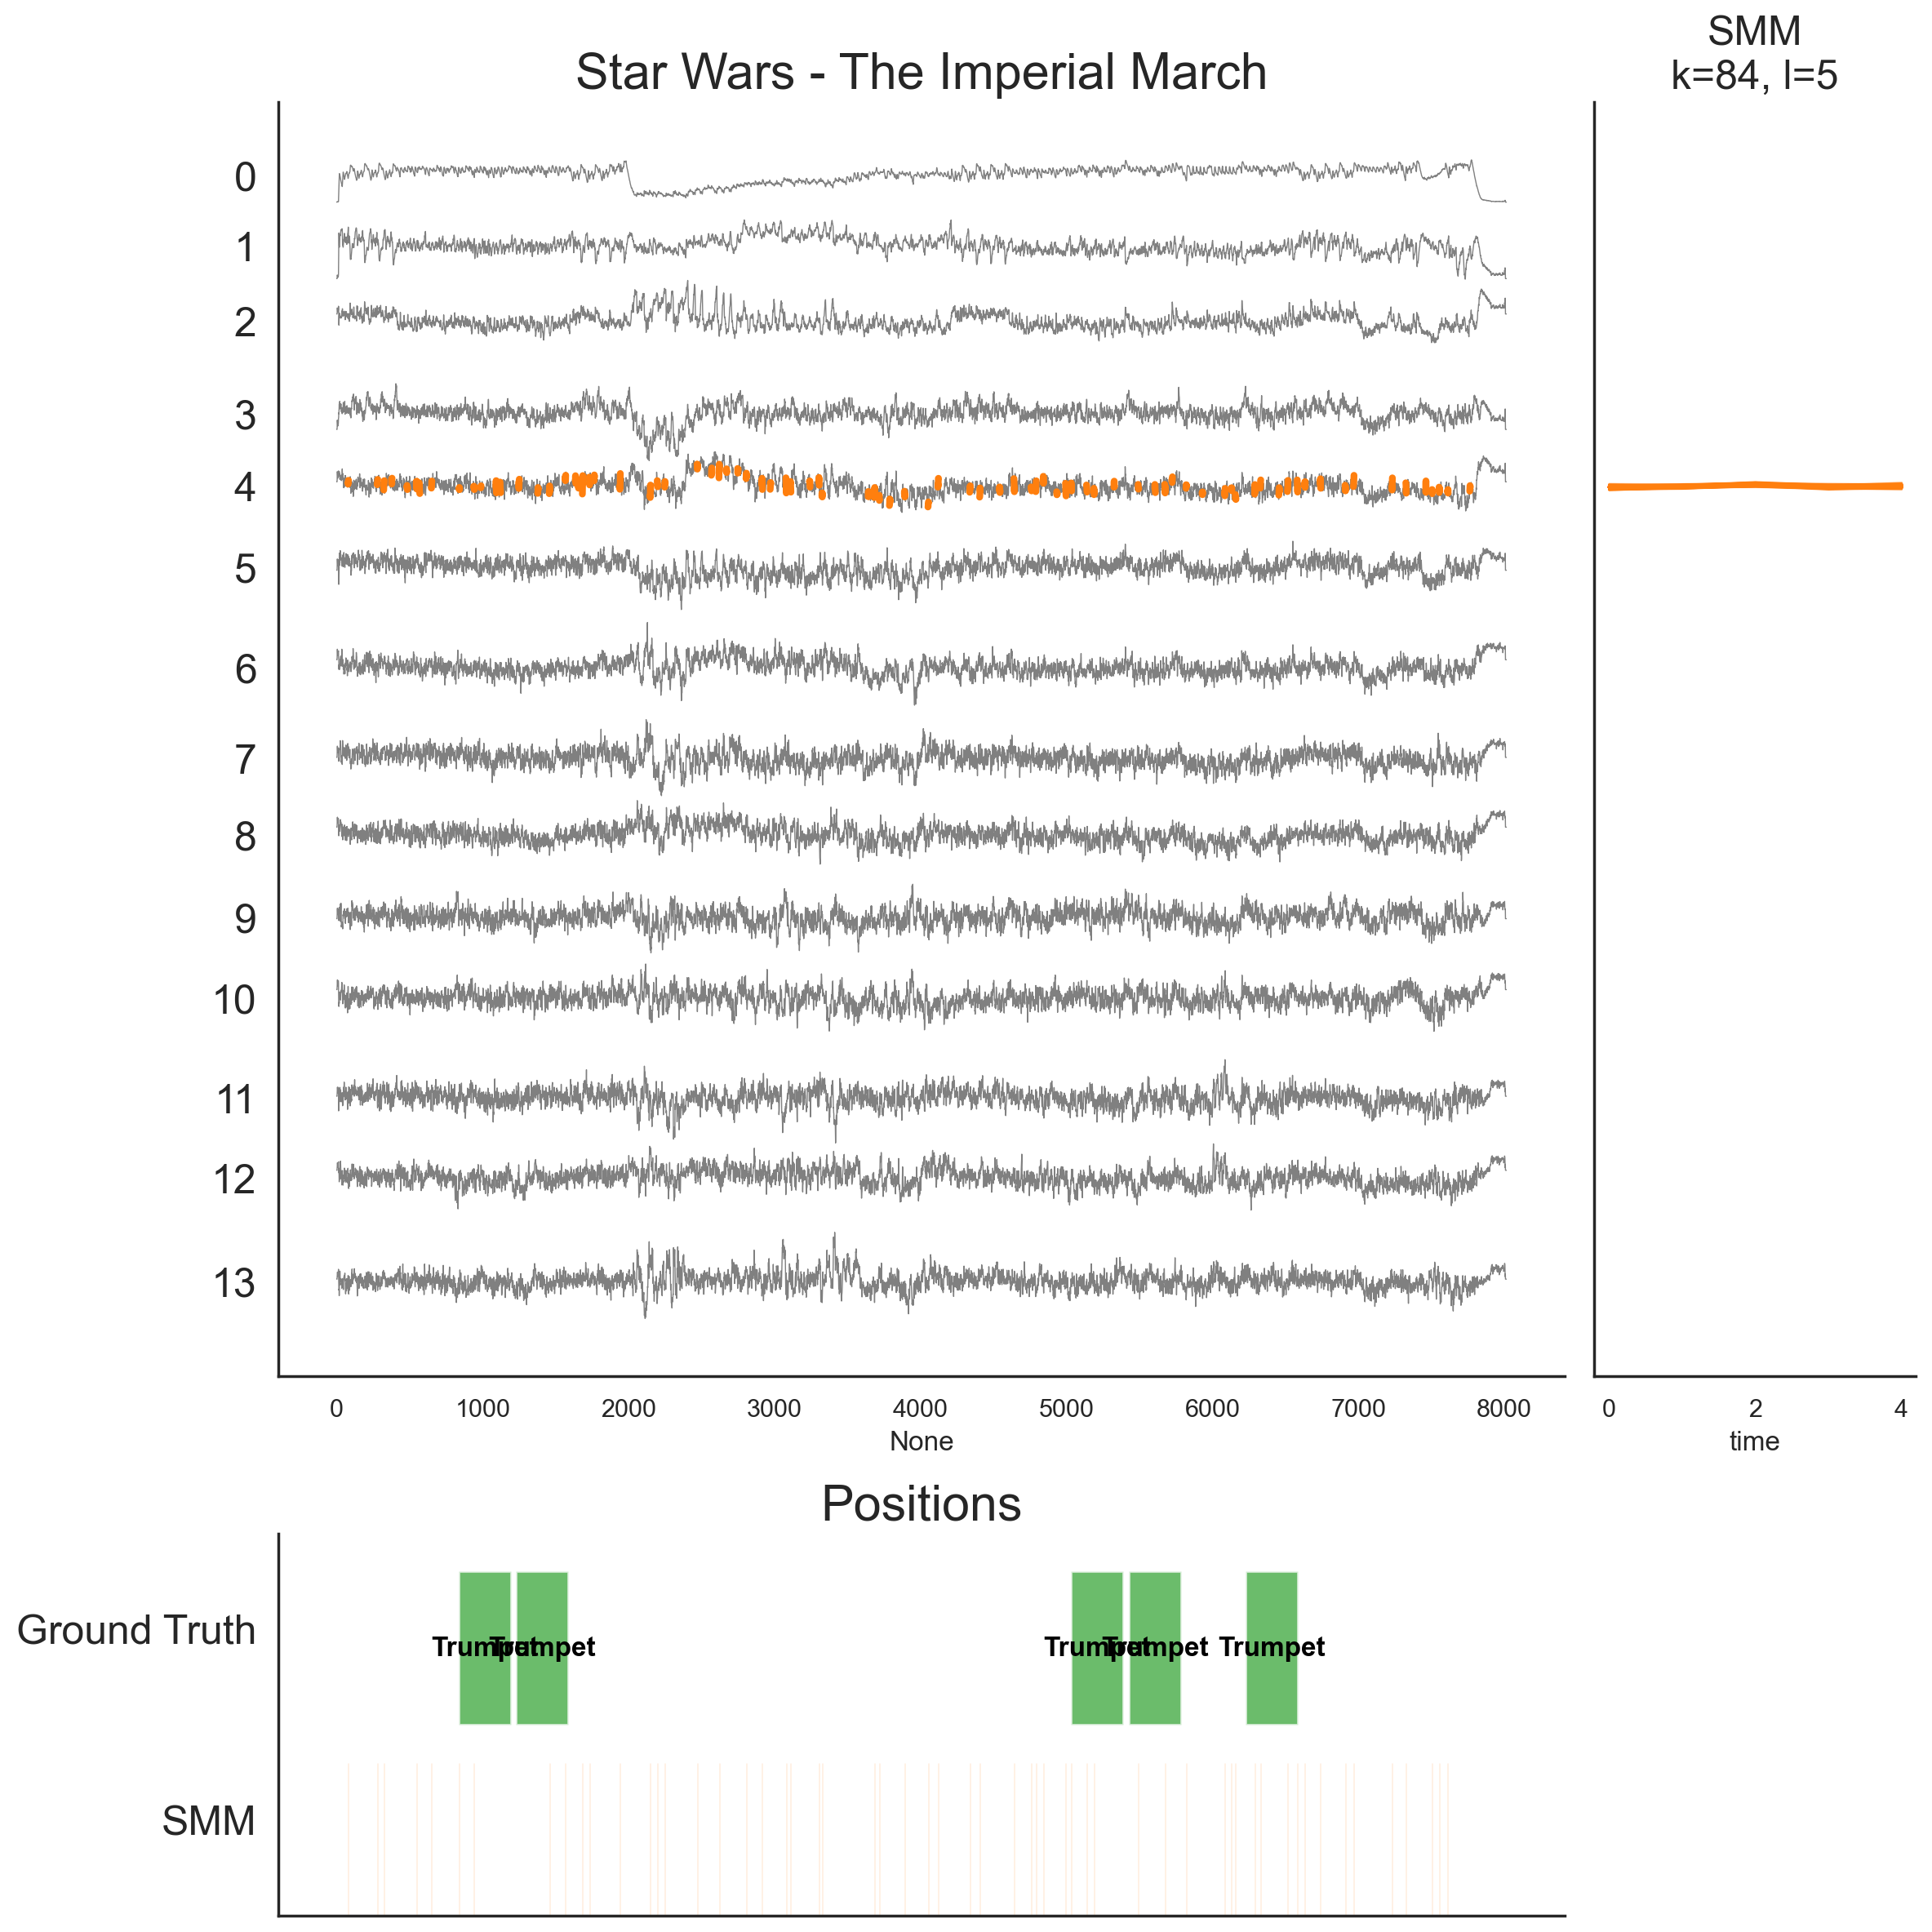

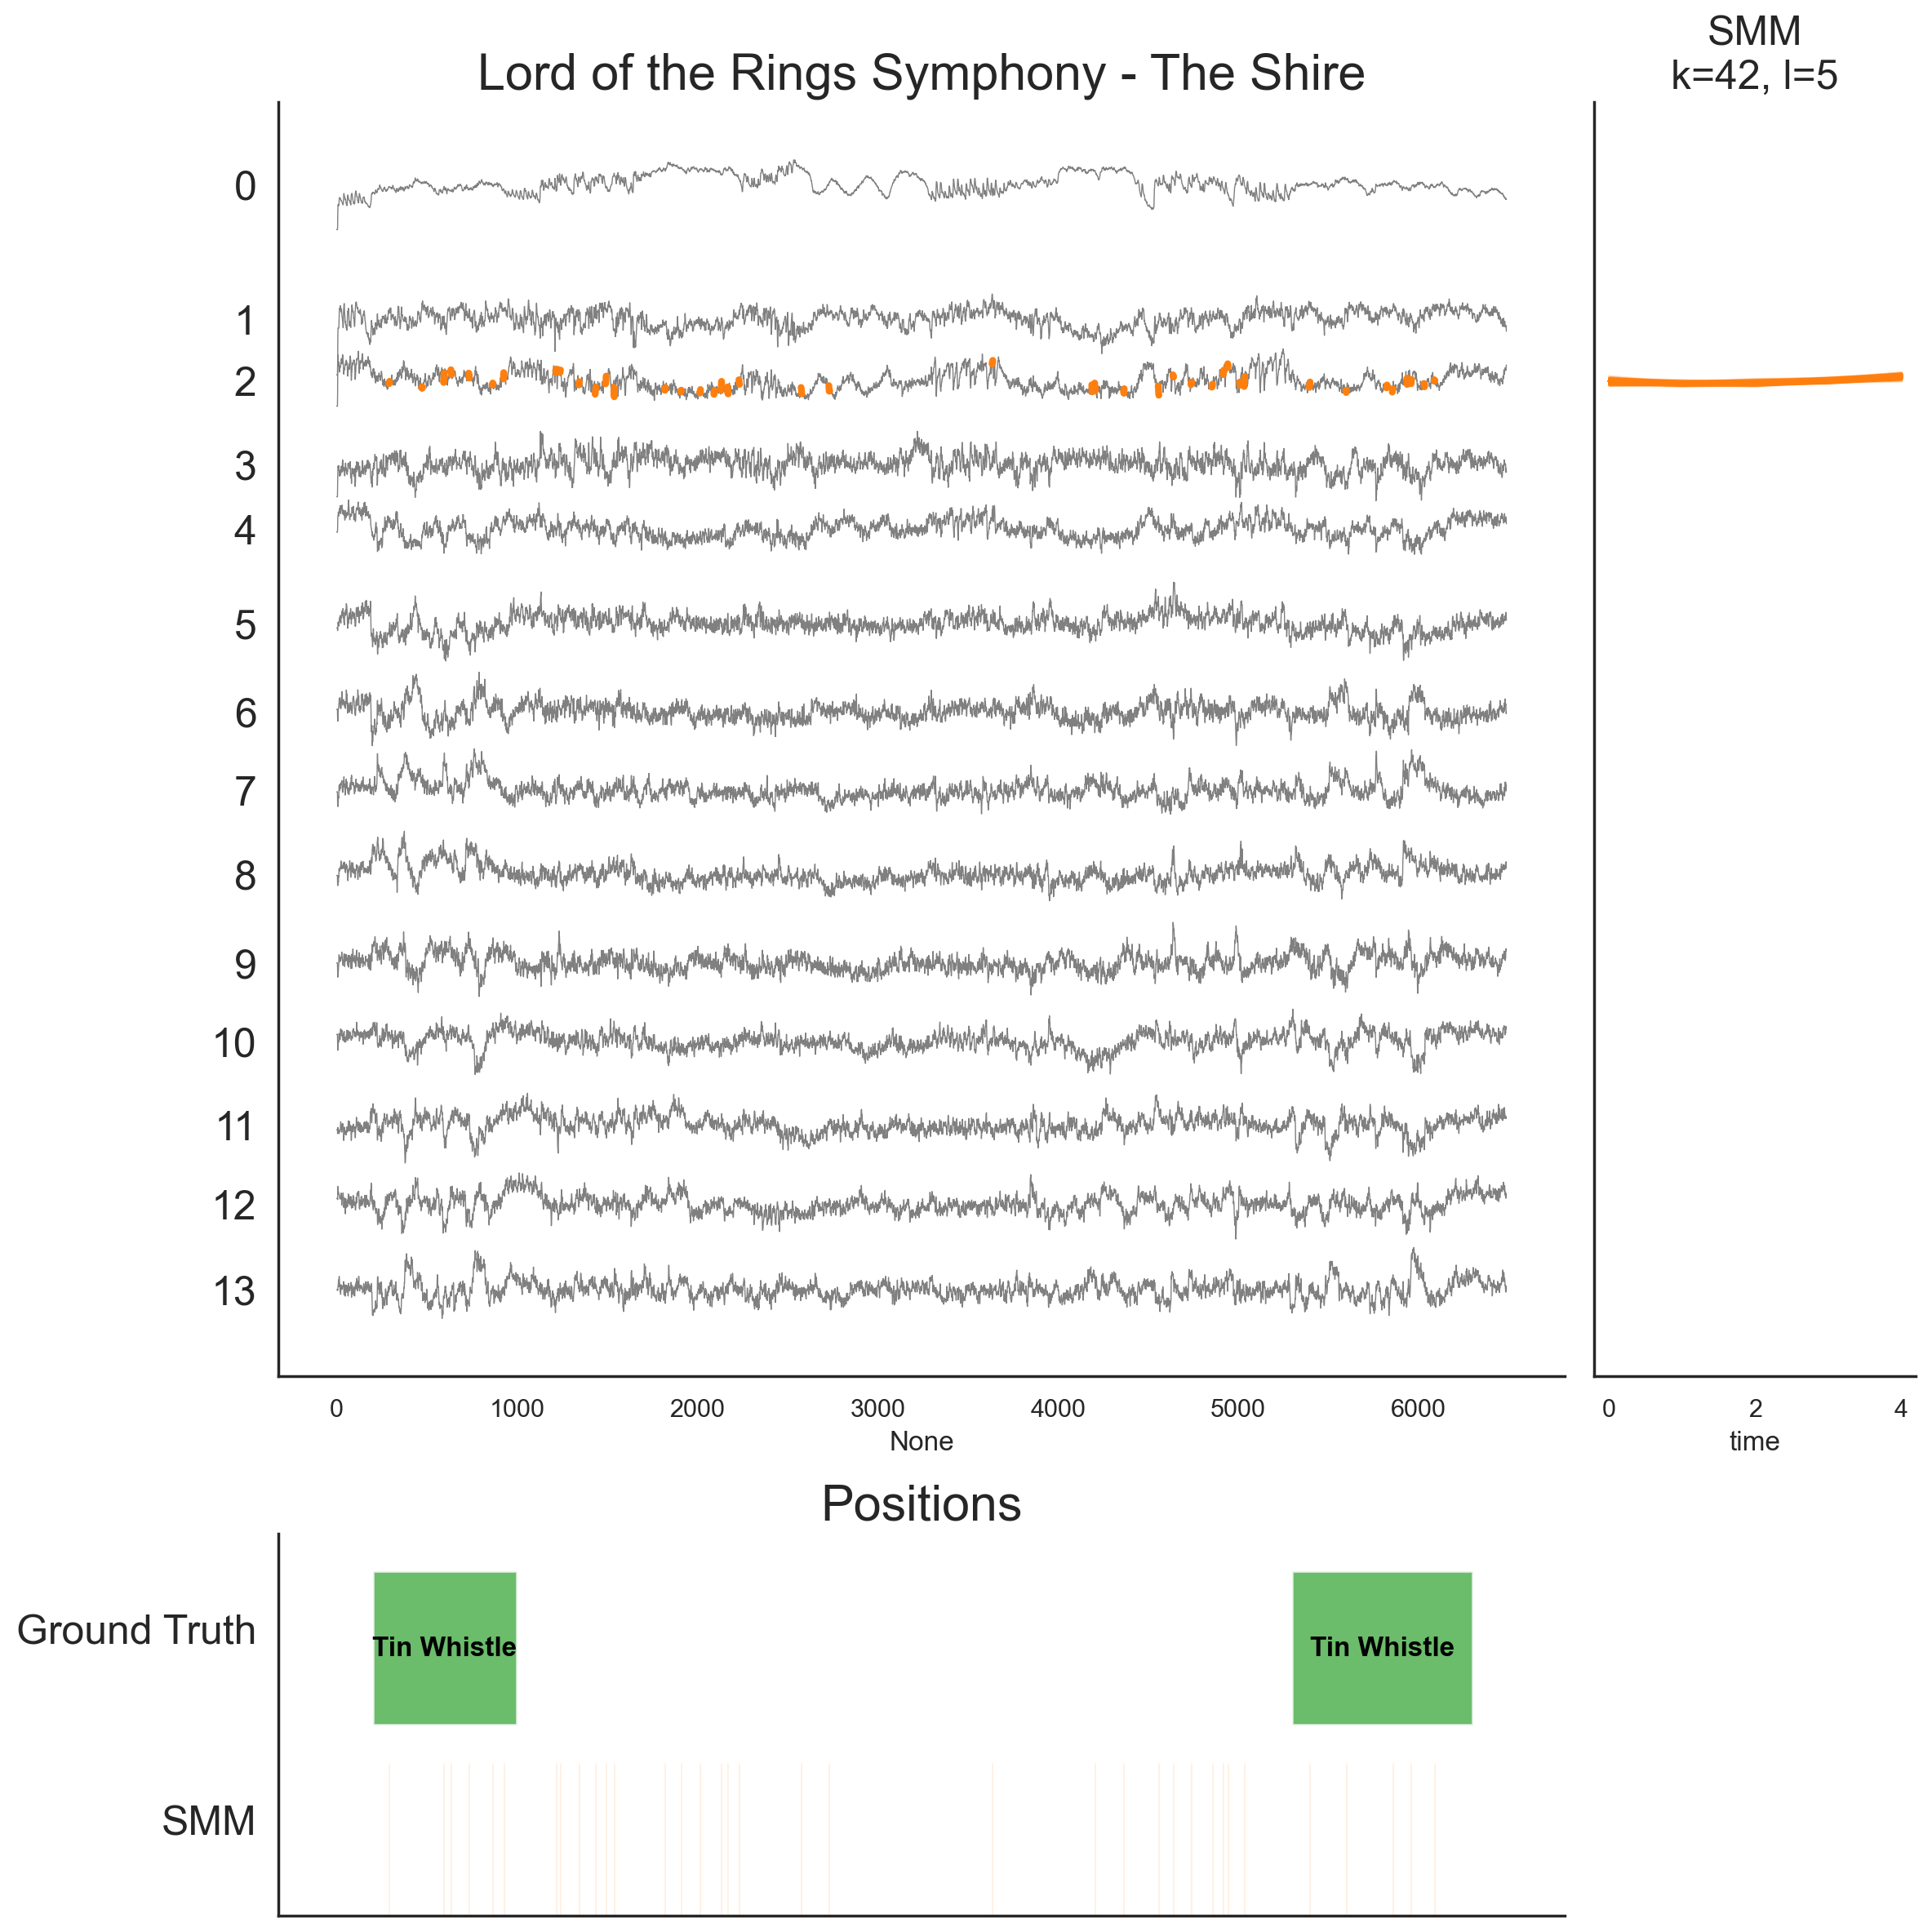

In [18]:
dataset_names = [
    'physio', 
    'Boxing', 
    'Swordplay', 
    'Basketball', 
    'Charleston - Side By Side Female', 
    'crypto', 
    'birds', 
    "What I've Done - Linkin Park",
    'Numb - Linkin Park', 
    'Vanilla Ice - Ice Ice Baby', 
    'Queen David Bowie - Under Pressure', 
    'The Rolling Stones - Paint It, Black', 
    'Star Wars - The Imperial March', 
    'Lord of the Rings Symphony - The Shire']


scores = {}
# Load the .mat file
for i in range(1, 15):

    series = pd.read_csv("smm_results/lama_benchmark/"+str(i)+".csv", header=None).T
    # file = "smm_results/lama_benchmark/Motif_"+str(i)+"_DepO_2_DepT_2.mat"
    file = "../tests/smm_benchmark/results/2/Motif_"+str(i)+"_DepO_2_DepT_2.mat"
    df_gt = read_ground_truth("smm_results/lama_benchmark/"+str(i)+".csv")

    """ only for plotting
    ml = LAMA(
        dataset_names[i-1],  
        series,
        dimension_labels=df.index,    
    )
    ml.plot_dataset()
    """

    # break
    # some dataset found no motifs
    if not os.path.exists(file):
        print(f"The file {file} does not exist.")
        continue

    print(dataset_names[i-1])
    
    mat_file = scipy.io.loadmat(file, struct_as_record=False, squeeze_me=True)
    motif_bag = mat_file["MotifBag"]
    
    if not isinstance(motif_bag, np.ndarray):
        motif_bag = [motif_bag]

    best_f_score = 0.0
    best_motif_set = []
    best_dims = []
    best_length = 0
    precision, recall = 0, 0
    
    for motif_bag in motif_bag:
        if motif_bag:
            startIdx = motif_bag.startIdx
            
            motif_set = startIdx
            dims = motif_bag.depd[0] - 1   #   matlab uses 1-indexing but python 0-indexing
            if not isinstance(dims, np.ndarray):
                dims = [dims]
            
            length = motif_bag.Tscope[0]            
            if length == 0:
                length = 1

            # plot_motiflet(series.values, motif_set, dims=dims, motif_length=length)
            # plt.show()

            precision, recall = compute_precision_recall(
                    np.sort(motif_set), df_gt.values[0, 0], length)                
            
            f_score = 2*(precision*recall) / (precision + recall + 1e-8)
            if f_score > best_f_score:
                best_f_score = f_score
                best_motif_set = motif_set
                best_length =  length
                best_dims = dims
                best_precision = precision
                best_recall = recall

    
    scores[i] = [dataset_names[i - 1], precision, recall]
    print("\t", scores[i])
    
    if len(best_motif_set)>0:
        if best_length == 1:
            best_length = 5
        print("\t", best_motif_set)
        print("\t", best_dims)
        print("\t", best_length)

        fig, axes = plot_motifsets(
            dataset_names[i - 1],
            series,
            motifsets=np.array([best_motif_set]),
            motifset_names=["SMM"],
            leitmotif_dims=np.array([best_dims]),
            motif_length=best_length,
            ground_truth=df_gt,
            show=False)

        plt.savefig("images/smm_"+str(i)+".pdf")

        # break

scores